In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [11]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, TimeDistributed
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098200,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,4
1098201,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,4
1098202,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,4
1098203,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,4


<Axes: xlabel='activity', ylabel='count'>

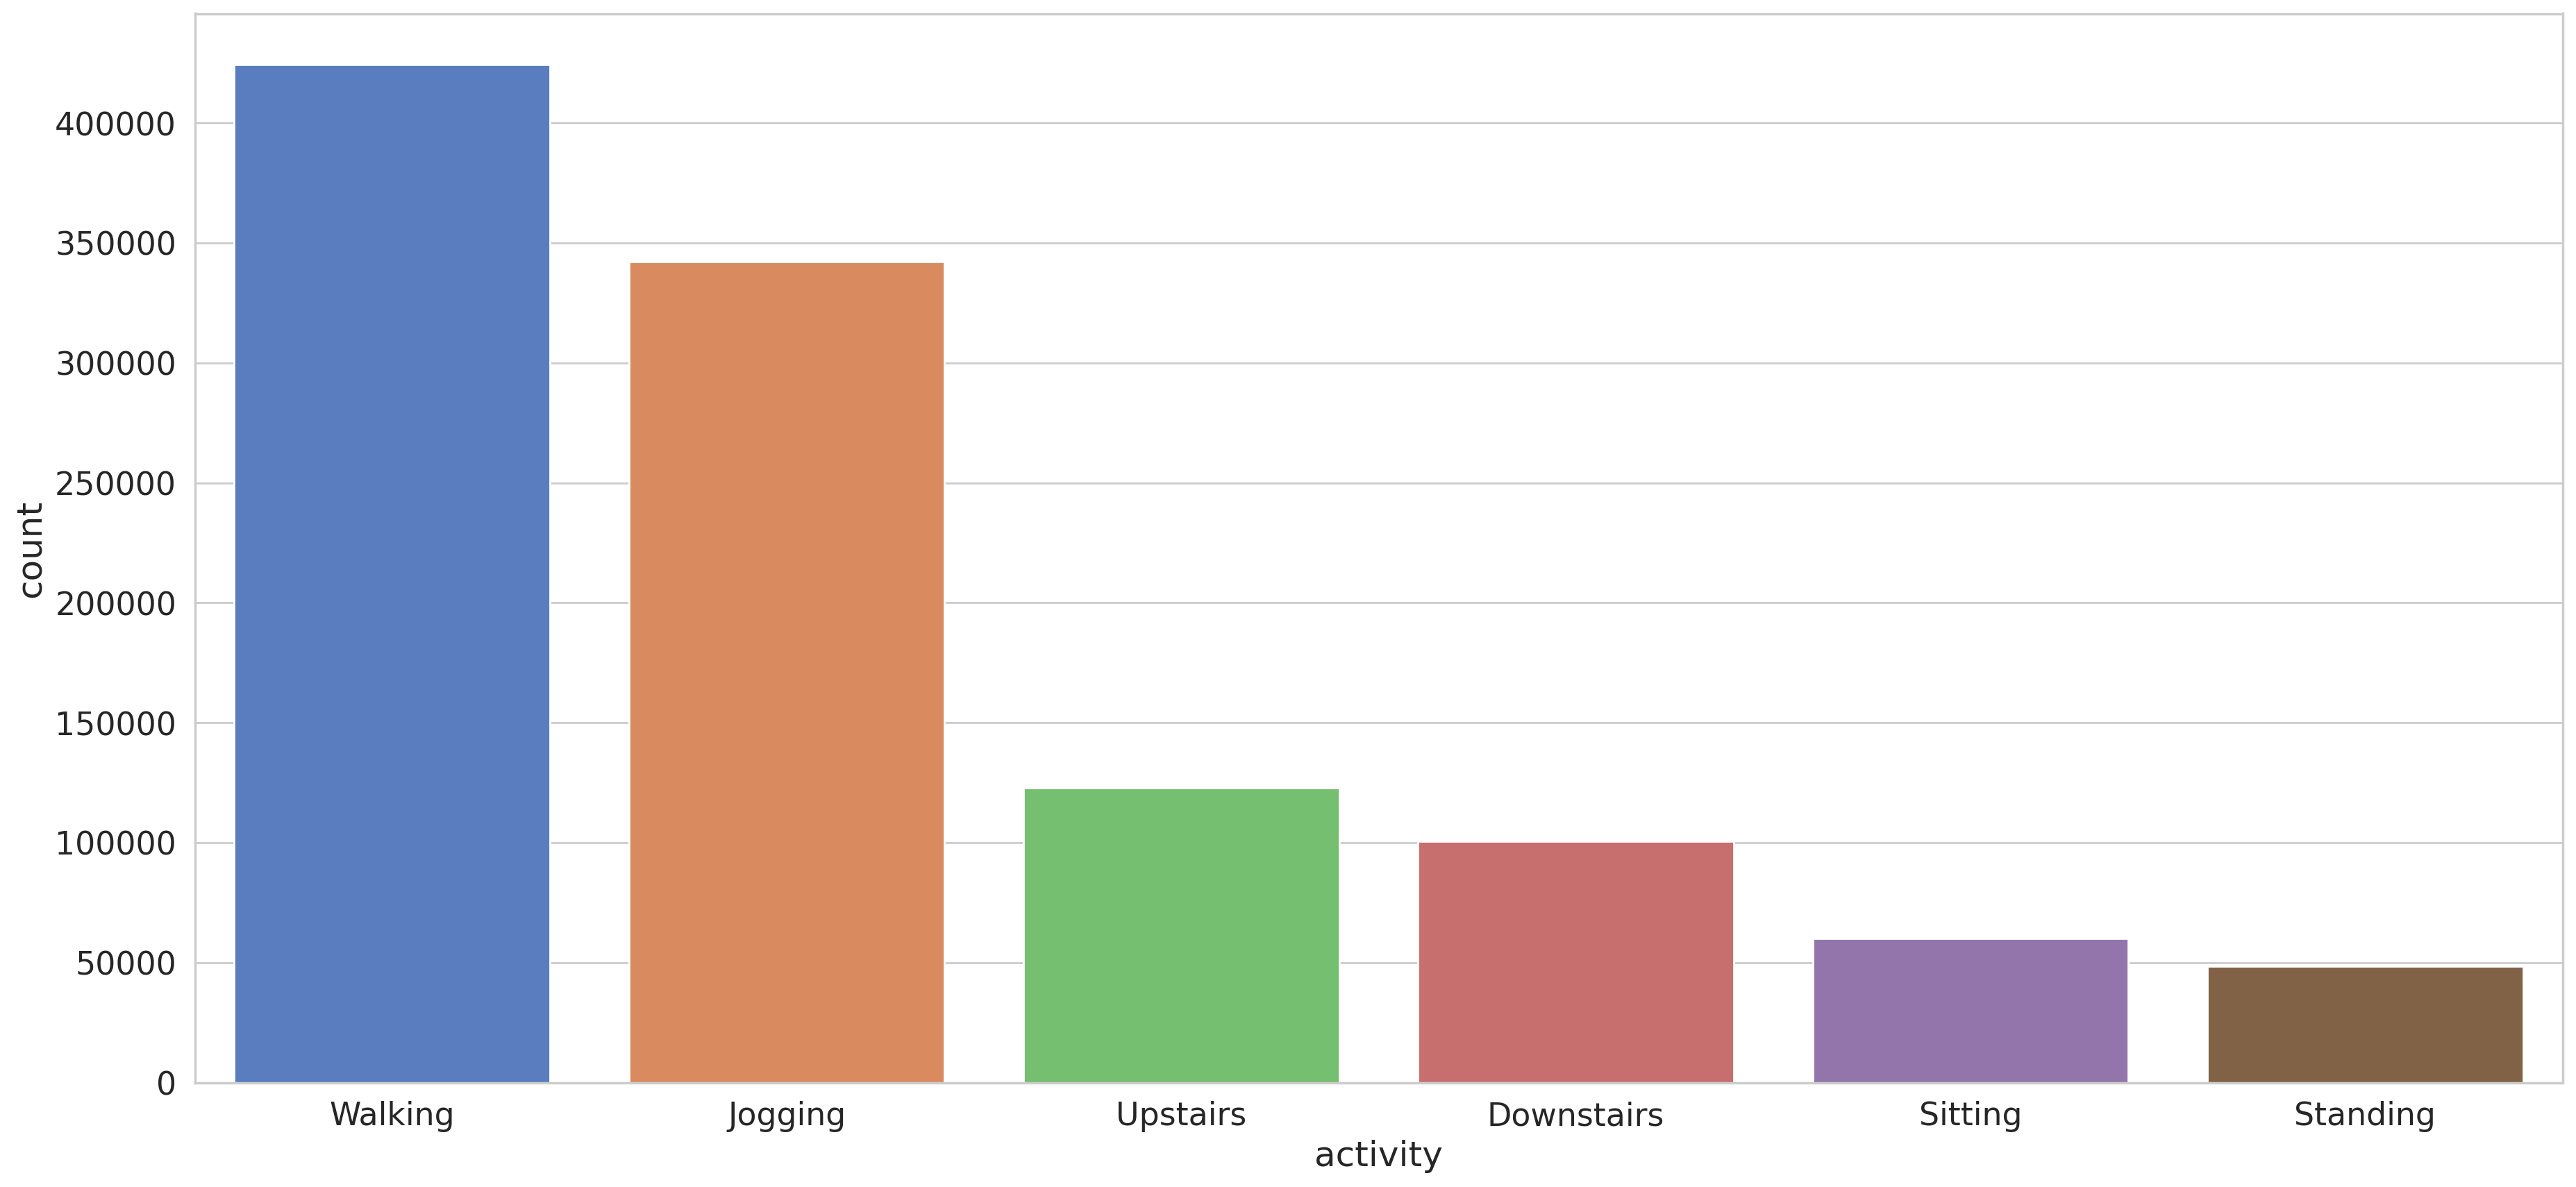

In [ ]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

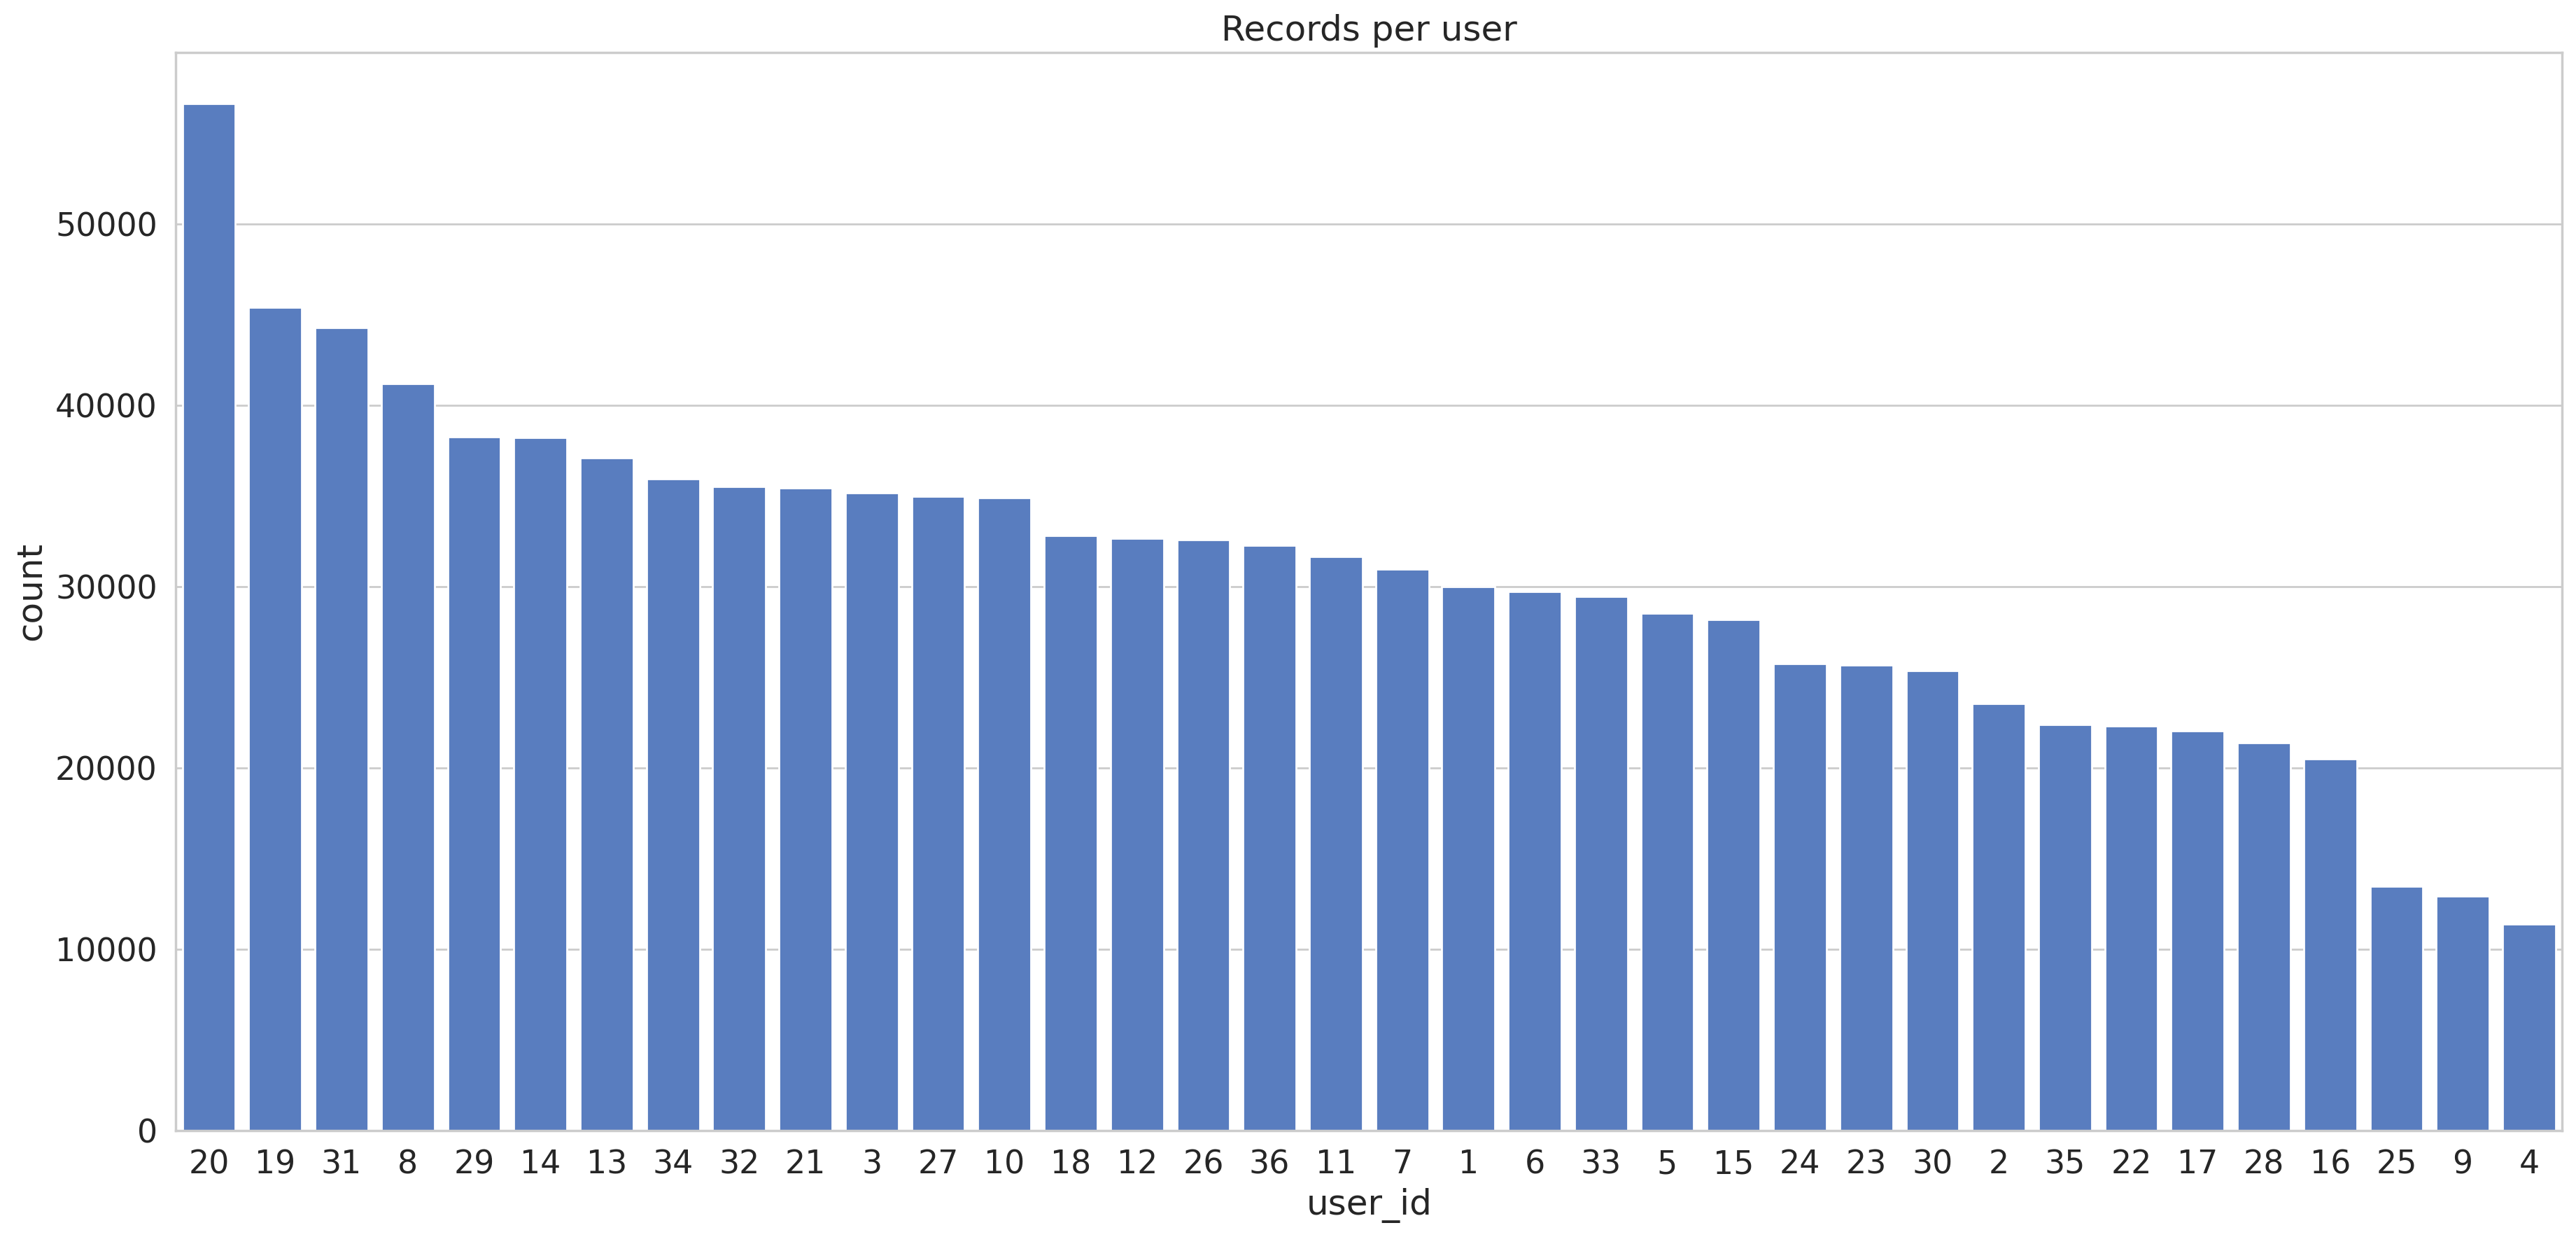

In [ ]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


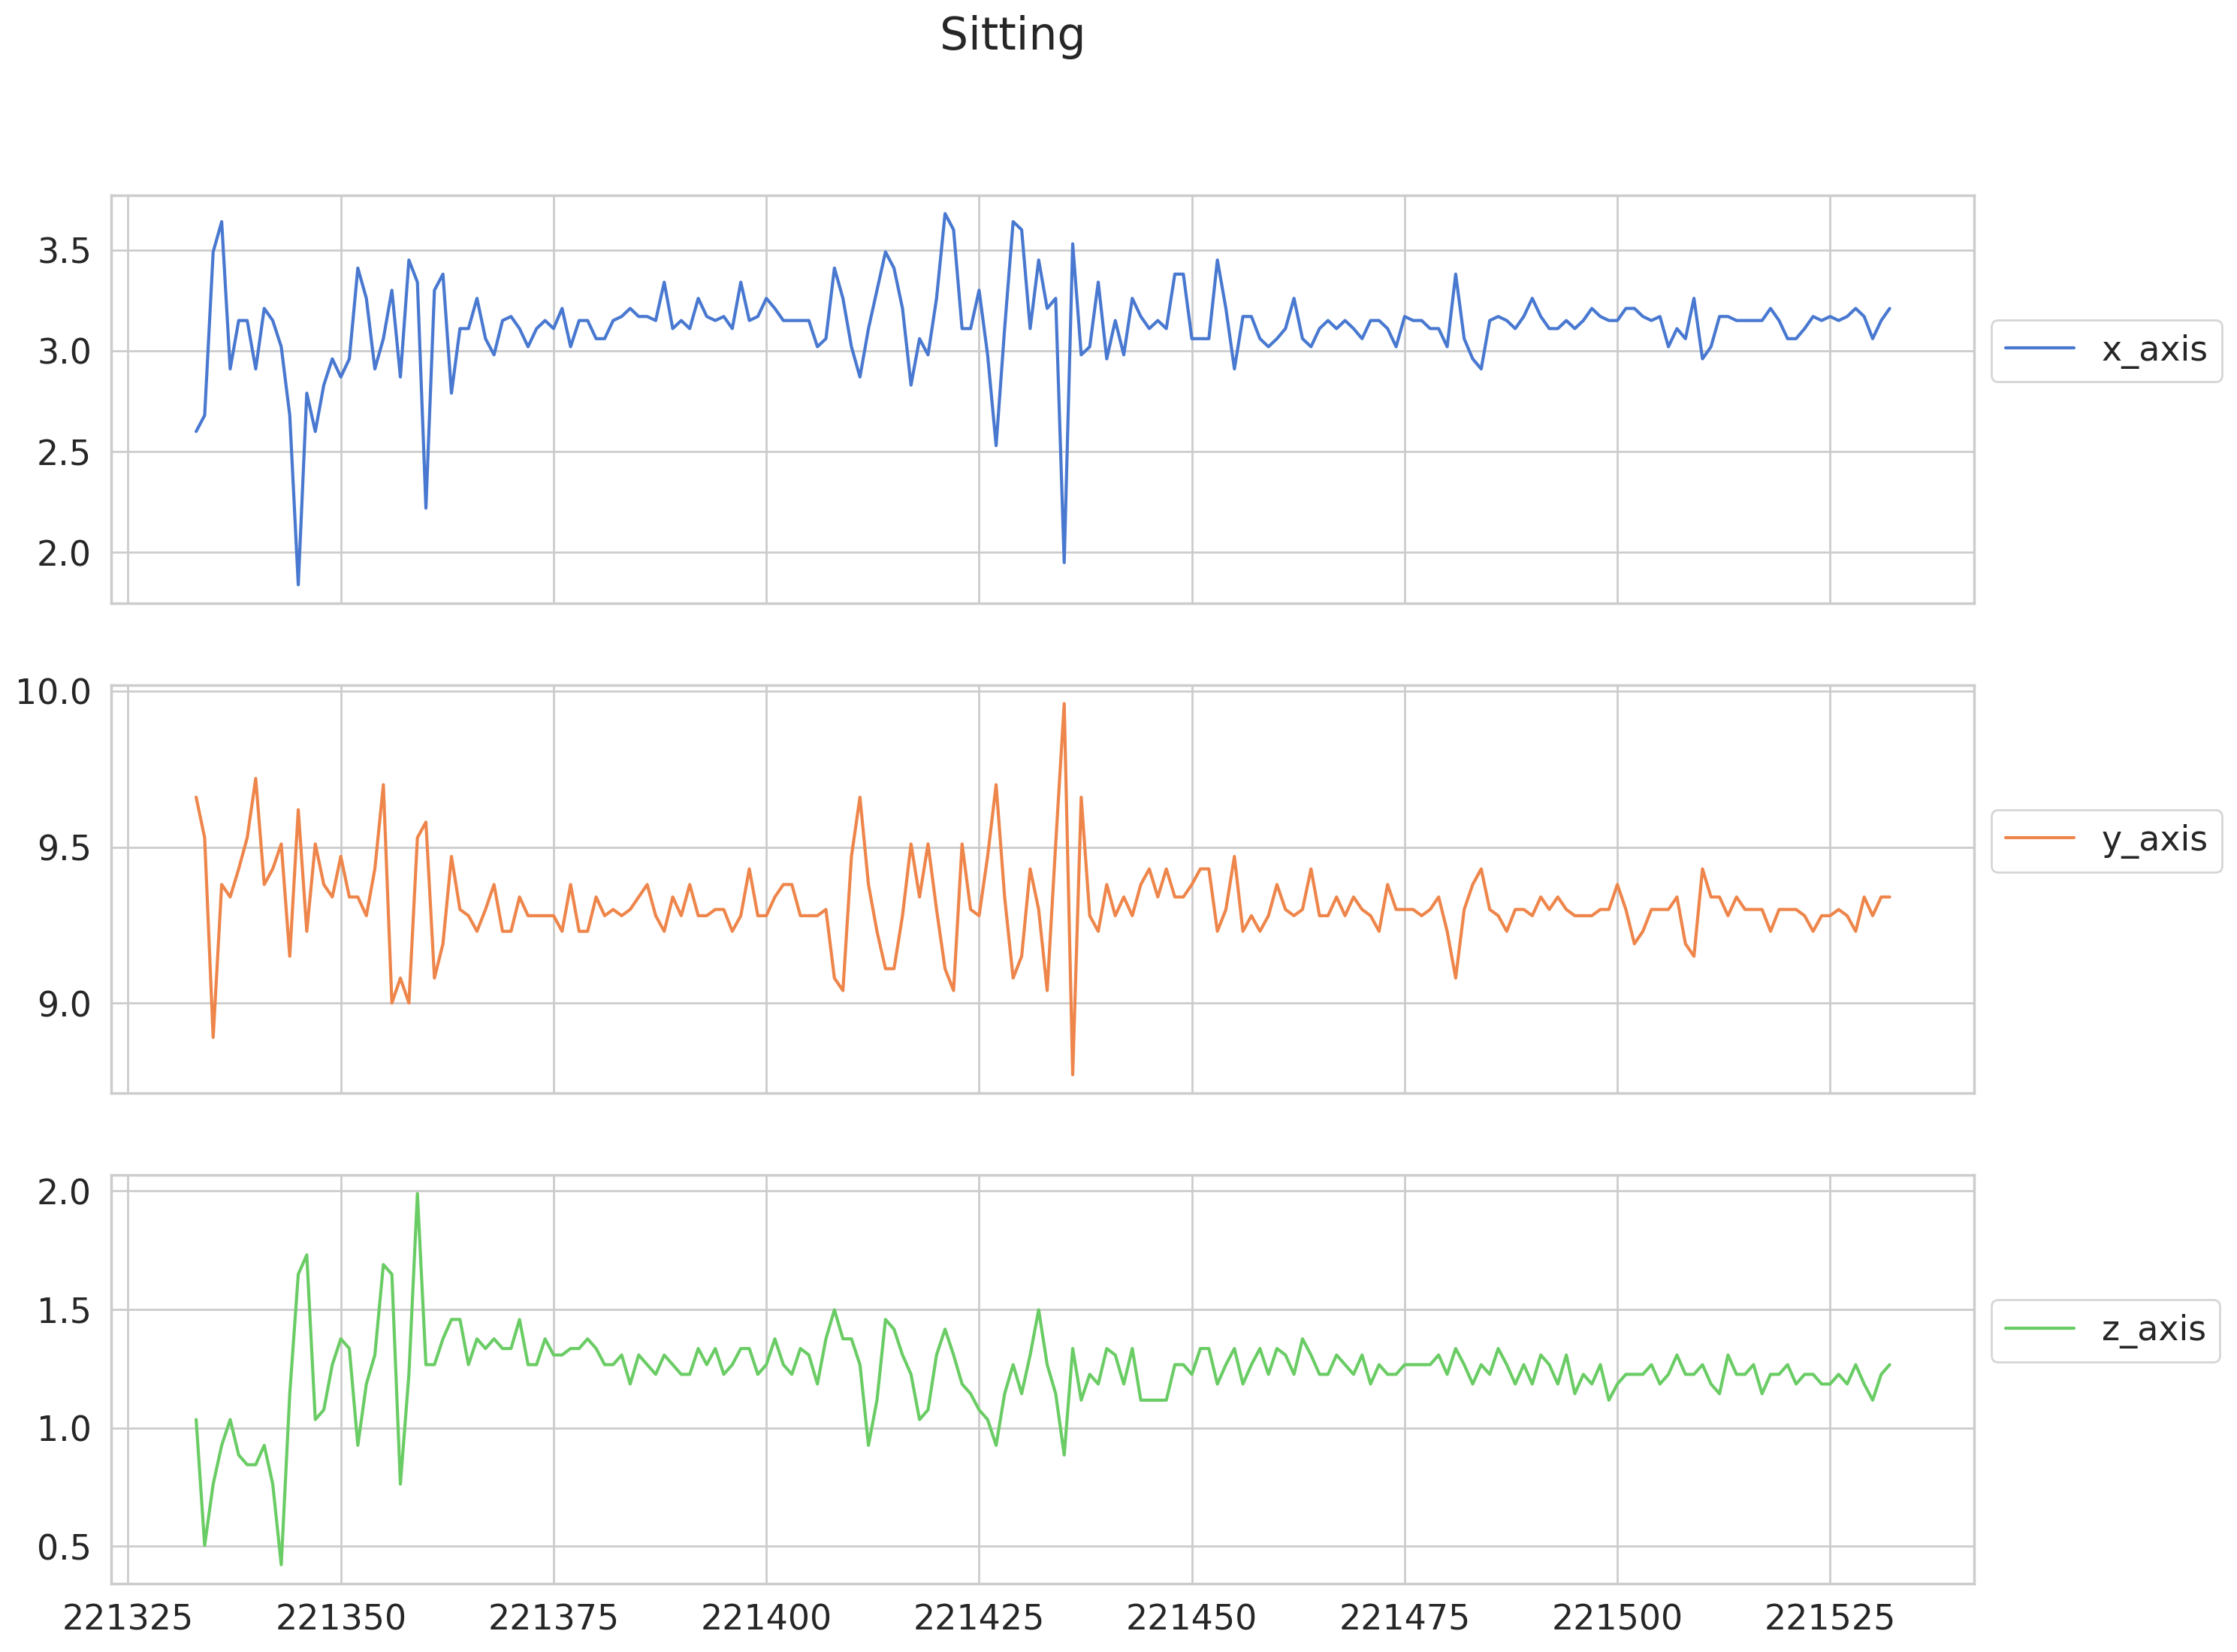

In [ ]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


In [ ]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.131961,0.566215,0.102015,1
1,33,Jogging,49106062271000,0.648740,0.397381,0.193001,1
2,33,Jogging,49106112167000,0.633834,0.351926,-0.016543,1
3,33,Jogging,49106222305000,-0.120782,1.259408,0.612089,1
4,33,Jogging,49106332290000,-0.199038,0.498032,1.458535,1
...,...,...,...,...,...,...,...
1098200,19,Sitting,131623331483000,1.194254,-1.132300,0.342105,4
1098201,19,Sitting,131623371431000,1.199726,-1.119190,0.350202,4
1098202,19,Sitting,131623411592000,1.205198,-1.109654,0.342105,4
1098203,19,Sitting,131623491487000,1.194254,-1.119190,0.350202,4


In [6]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)
X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
n_steps = 4
n_features = X_train.shape[2]
n_length = 50

X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, n_length, n_features))

(17568, 200, 3) (17568, 1)
(5491, 200, 3) (5491, 1)


In [7]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(17568, 4, 50, 3) (17568, 6) (5491, 4, 50, 3) (5491, 6)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
#Epoch 500

BATCH_SIZE = 32

verbose,epochs,batch_size=1,10, BATCH_SIZE

#Epoch 500

BATCH_SIZE = 32

verbose,epochs,batch_size=1,10, BATCH_SIZE

n_timesteps, n_features, n_outputs = n_steps * n_length, X_train.shape[3], y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 3, 6)

# CNN1 - LSTM1

In [12]:
# Model 1
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 48, 64)      640       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, None, 48, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, None, 24, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, None, 1536)        0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)              

In [13]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
138/138 [==============================] - 28s 131ms/step - loss: 0.8208 - accuracy: 0.7156 - val_loss: 0.5213 - val_accuracy: 0.8101
Epoch 2/10
138/138 [==============================] - 15s 108ms/step - loss: 0.5010 - accuracy: 0.8196 - val_loss: 0.3759 - val_accuracy: 0.8497
Epoch 3/10
138/138 [==============================] - 15s 108ms/step - loss: 0.4182 - accuracy: 0.8452 - val_loss: 0.3253 - val_accuracy: 0.8741
Epoch 4/10
138/138 [==============================] - 15s 110ms/step - loss: 0.3497 - accuracy: 0.8683 - val_loss: 0.2820 - val_accuracy: 0.8889
Epoch 5/10
138/138 [==============================] - 15s 108ms/step - loss: 0.3070 - accuracy: 0.8846 - val_loss: 0.2923 - val_accuracy: 0.8948
Epoch 6/10
138/138 [==============================] - 16s 116ms/step - loss: 0.2716 - accuracy: 0.8984 - val_loss: 0.2284 - val_accuracy: 0.9087
Epoch 7/10
138/138 [==============================] - 17s 121ms/step - loss: 0.2390 - accuracy: 0.9123 - val_loss: 0.1894 - val_ac

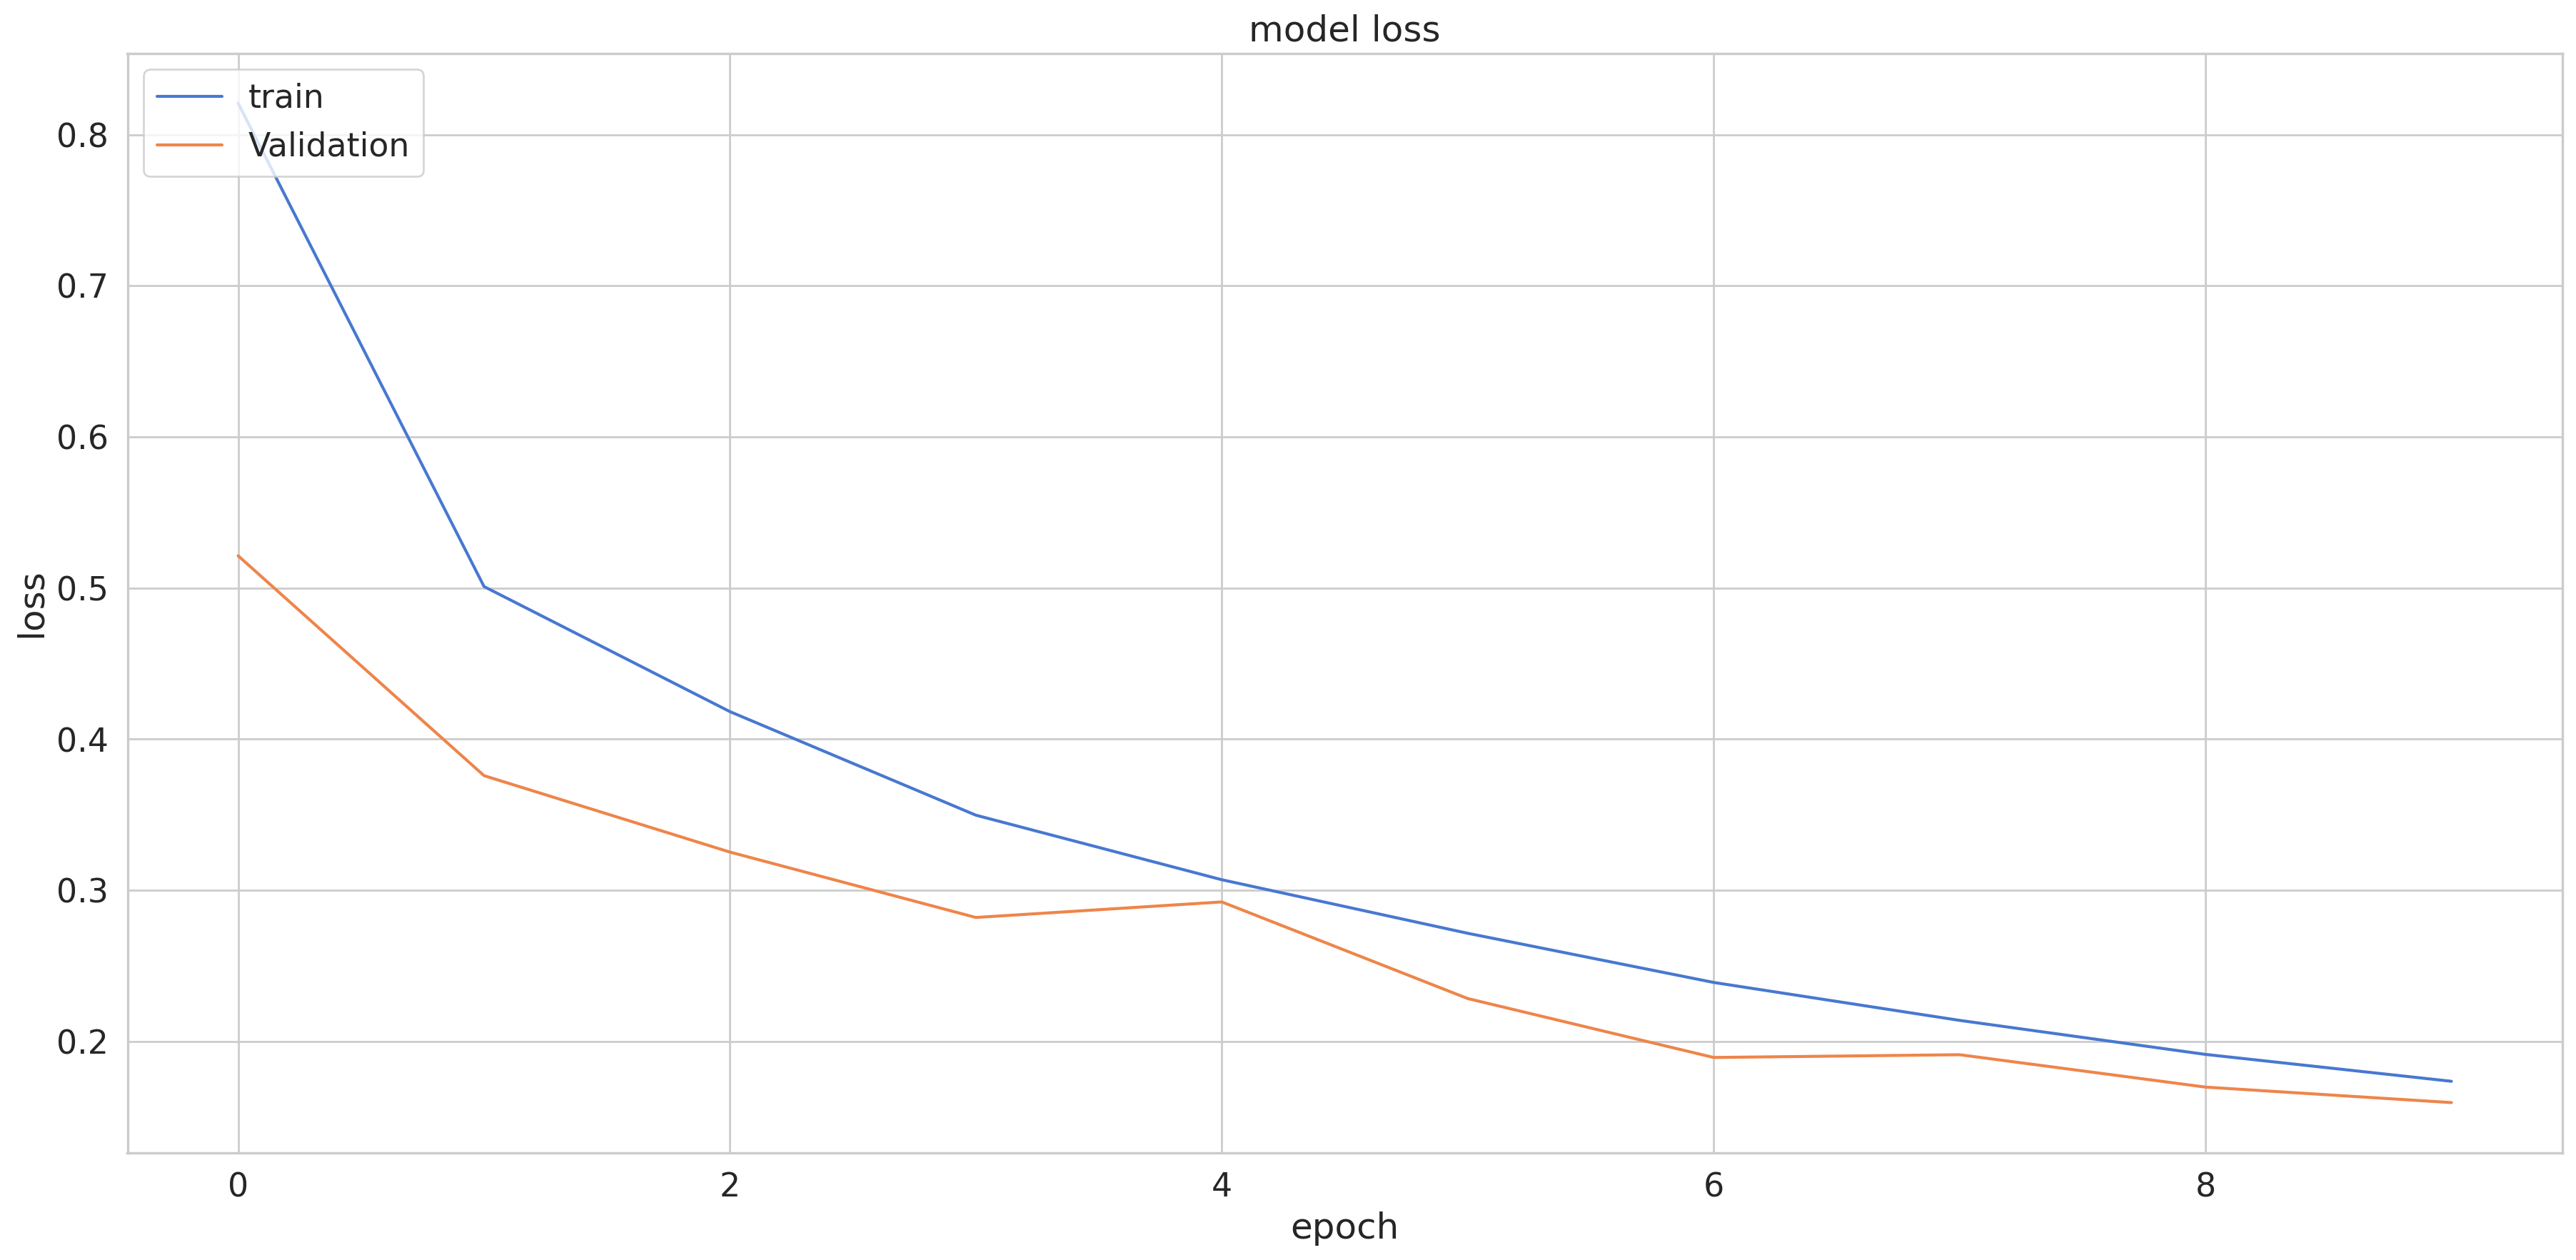

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

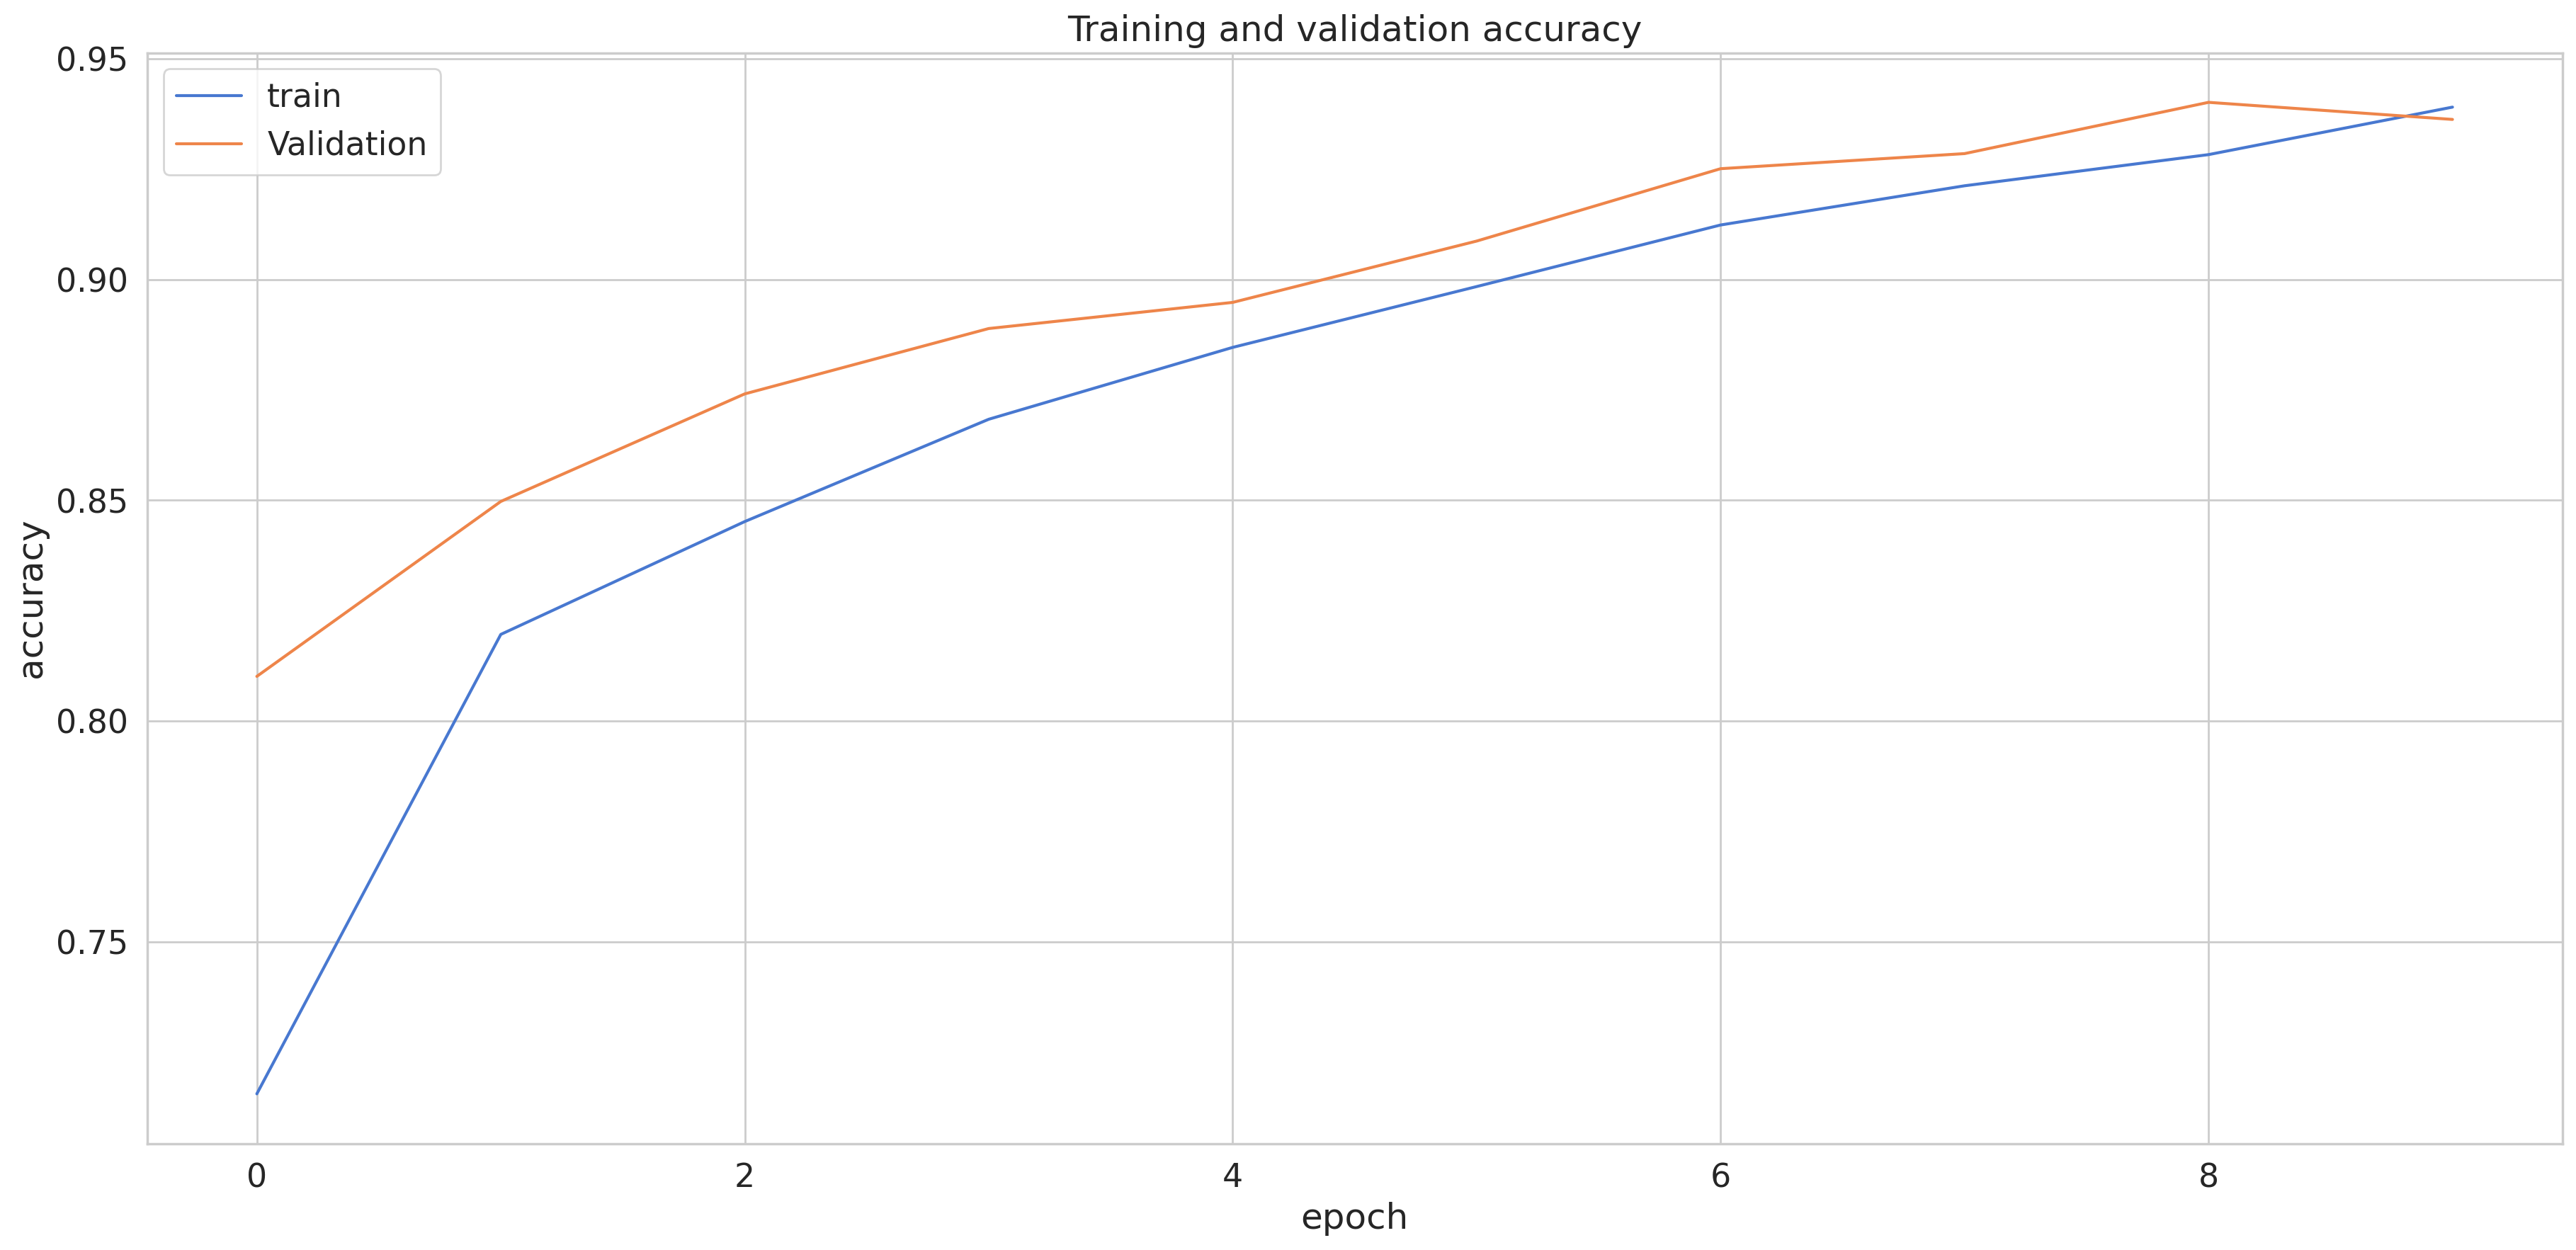

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

172/172 [==============================] - 3s 15ms/step
f1_score =  0.9382547759036787
0.9399016572573302
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2123
           1       0.96      0.99      0.97      1710
           2       0.88      0.67      0.76       614
           3       0.77      0.88      0.82       503
           4       0.99      0.97      0.98       300
           5       0.98      0.98      0.98       241

    accuracy                           0.94      5491
   macro avg       0.92      0.91      0.91      5491
weighted avg       0.94      0.94      0.94      5491



<Axes: >

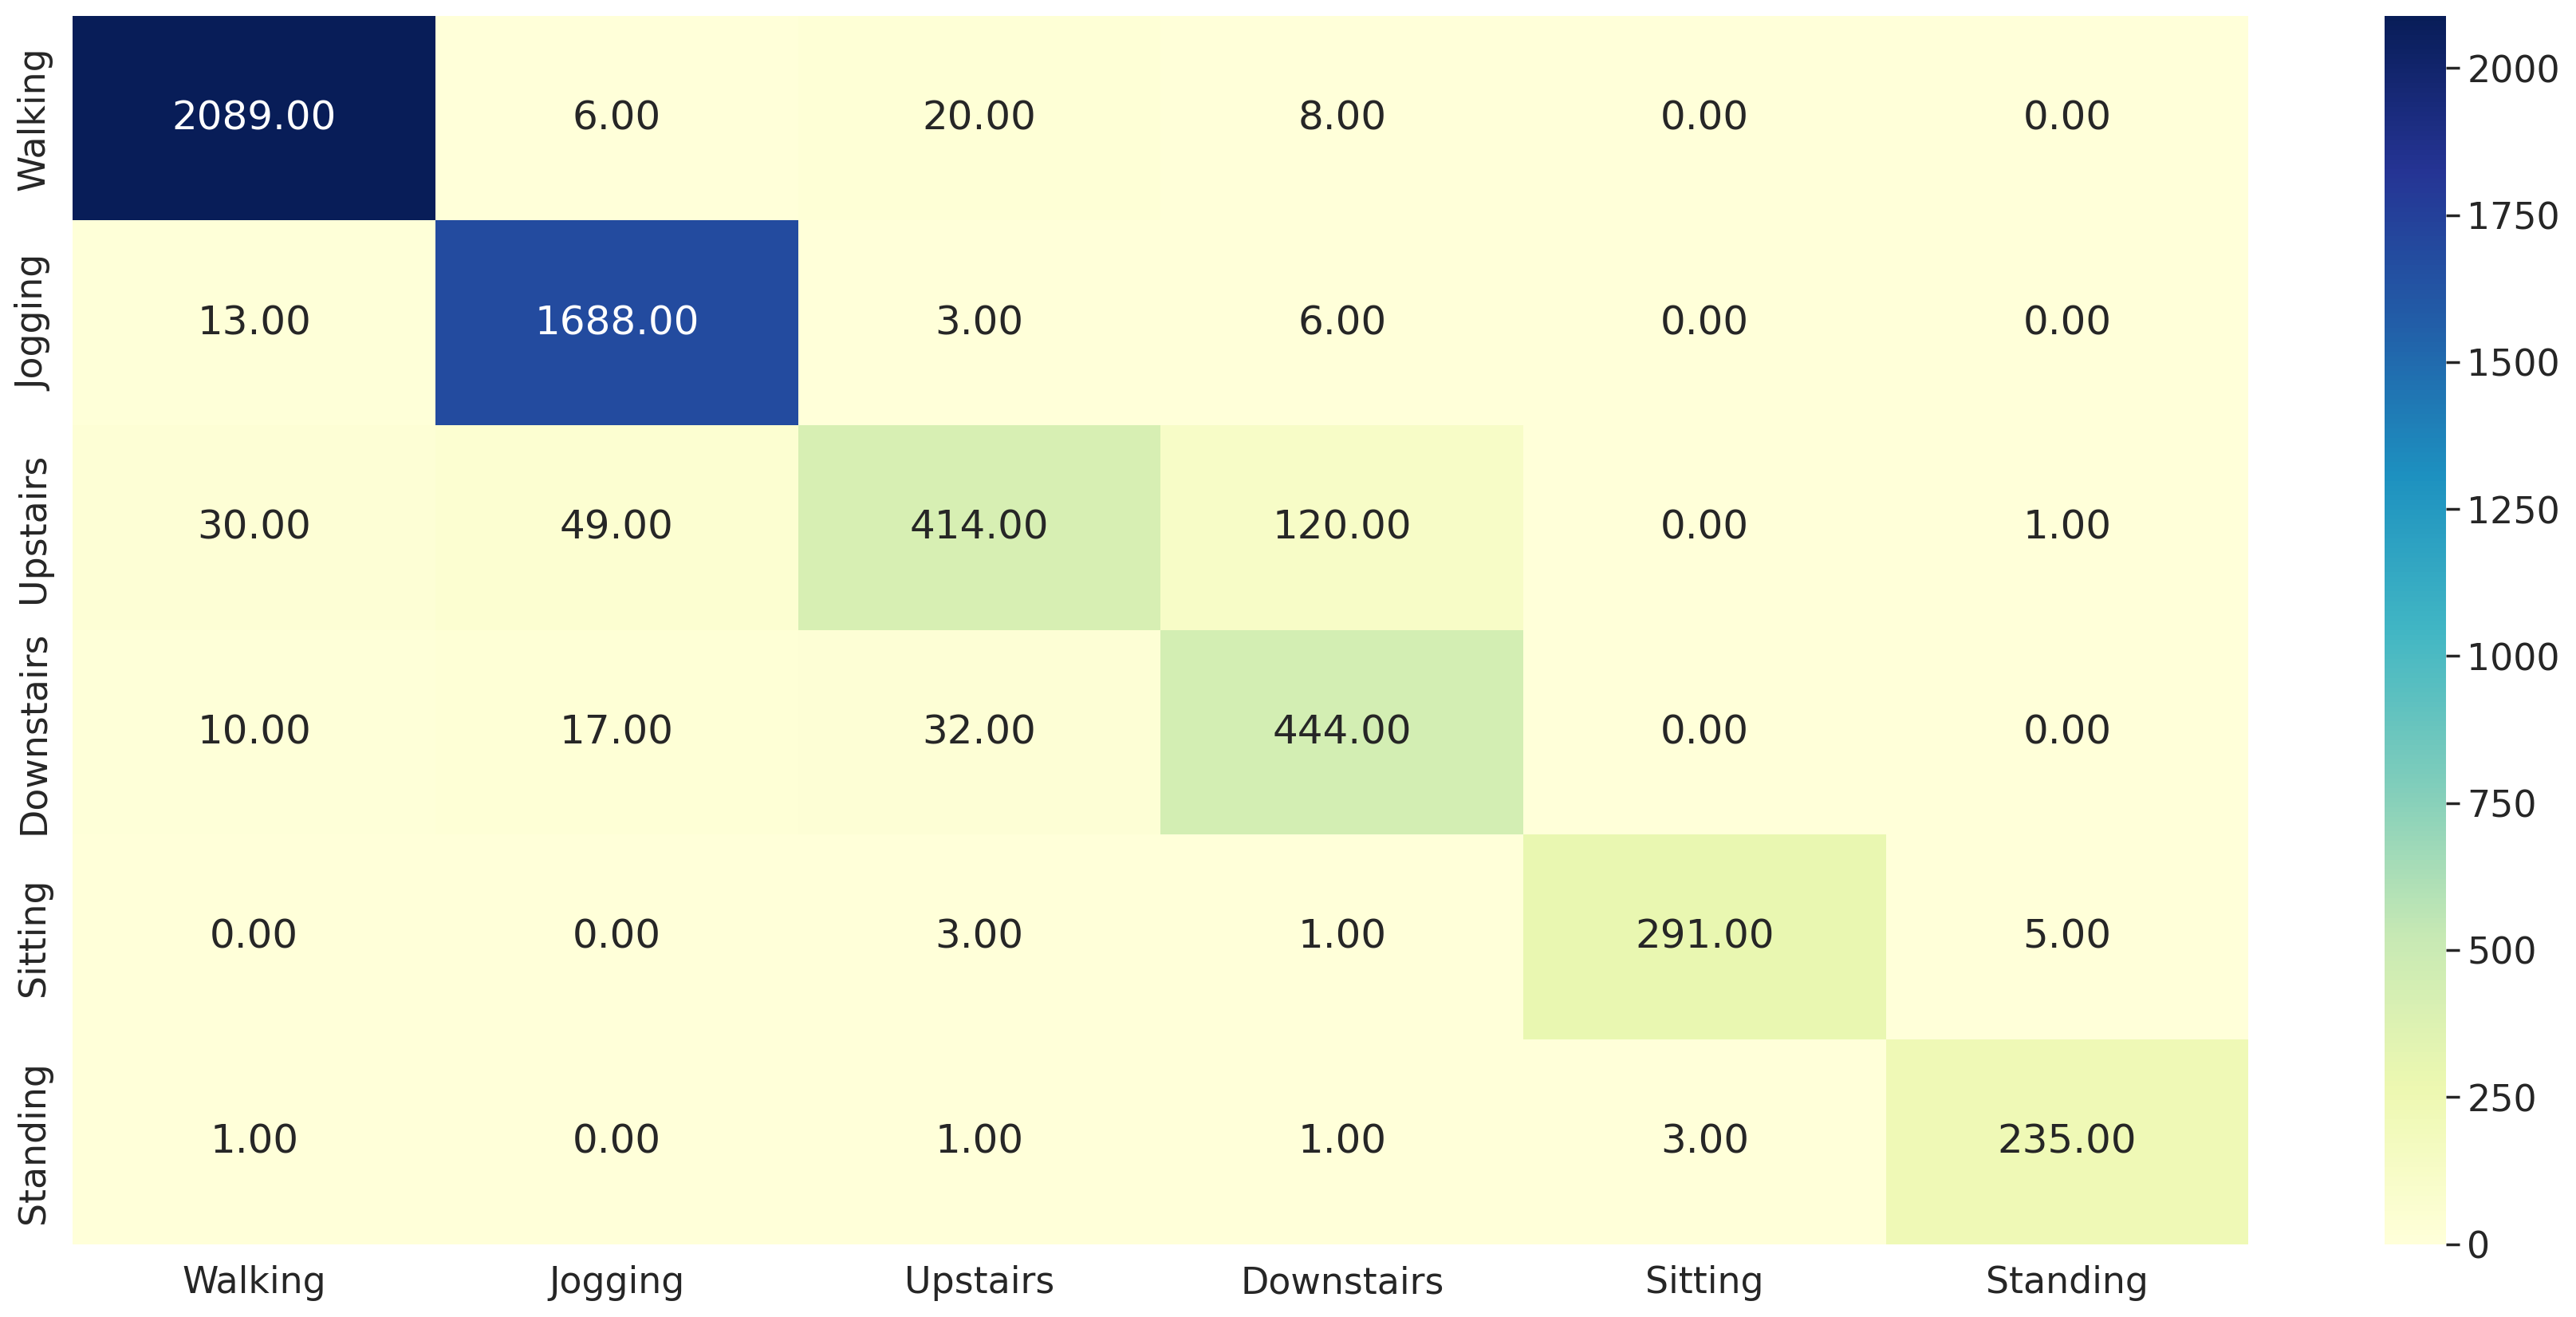

In [17]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN1 - LSTM2

In [18]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, None, 48, 64)      640       
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, None, 48, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, None, 24, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, None, 1536)        0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, None, 100)        

In [19]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
138/138 [==============================] - 26s 127ms/step - loss: 0.7820 - accuracy: 0.7320 - val_loss: 0.4939 - val_accuracy: 0.8222
Epoch 2/10
138/138 [==============================] - 17s 123ms/step - loss: 0.4691 - accuracy: 0.8267 - val_loss: 0.4864 - val_accuracy: 0.8379
Epoch 3/10
138/138 [==============================] - 17s 122ms/step - loss: 0.3628 - accuracy: 0.8642 - val_loss: 0.2877 - val_accuracy: 0.8800
Epoch 4/10
138/138 [==============================] - 21s 151ms/step - loss: 0.2920 - accuracy: 0.8844 - val_loss: 0.2654 - val_accuracy: 0.8934
Epoch 5/10
138/138 [==============================] - 23s 164ms/step - loss: 0.2548 - accuracy: 0.9001 - val_loss: 0.2341 - val_accuracy: 0.9139
Epoch 6/10
138/138 [==============================] - 17s 123ms/step - loss: 0.2184 - accuracy: 0.9215 - val_loss: 0.1942 - val_accuracy: 0.9278
Epoch 7/10
138/138 [==============================] - 23s 168ms/step - loss: 0.1932 - accuracy: 0.9288 - val_loss: 0.1967 - val_ac

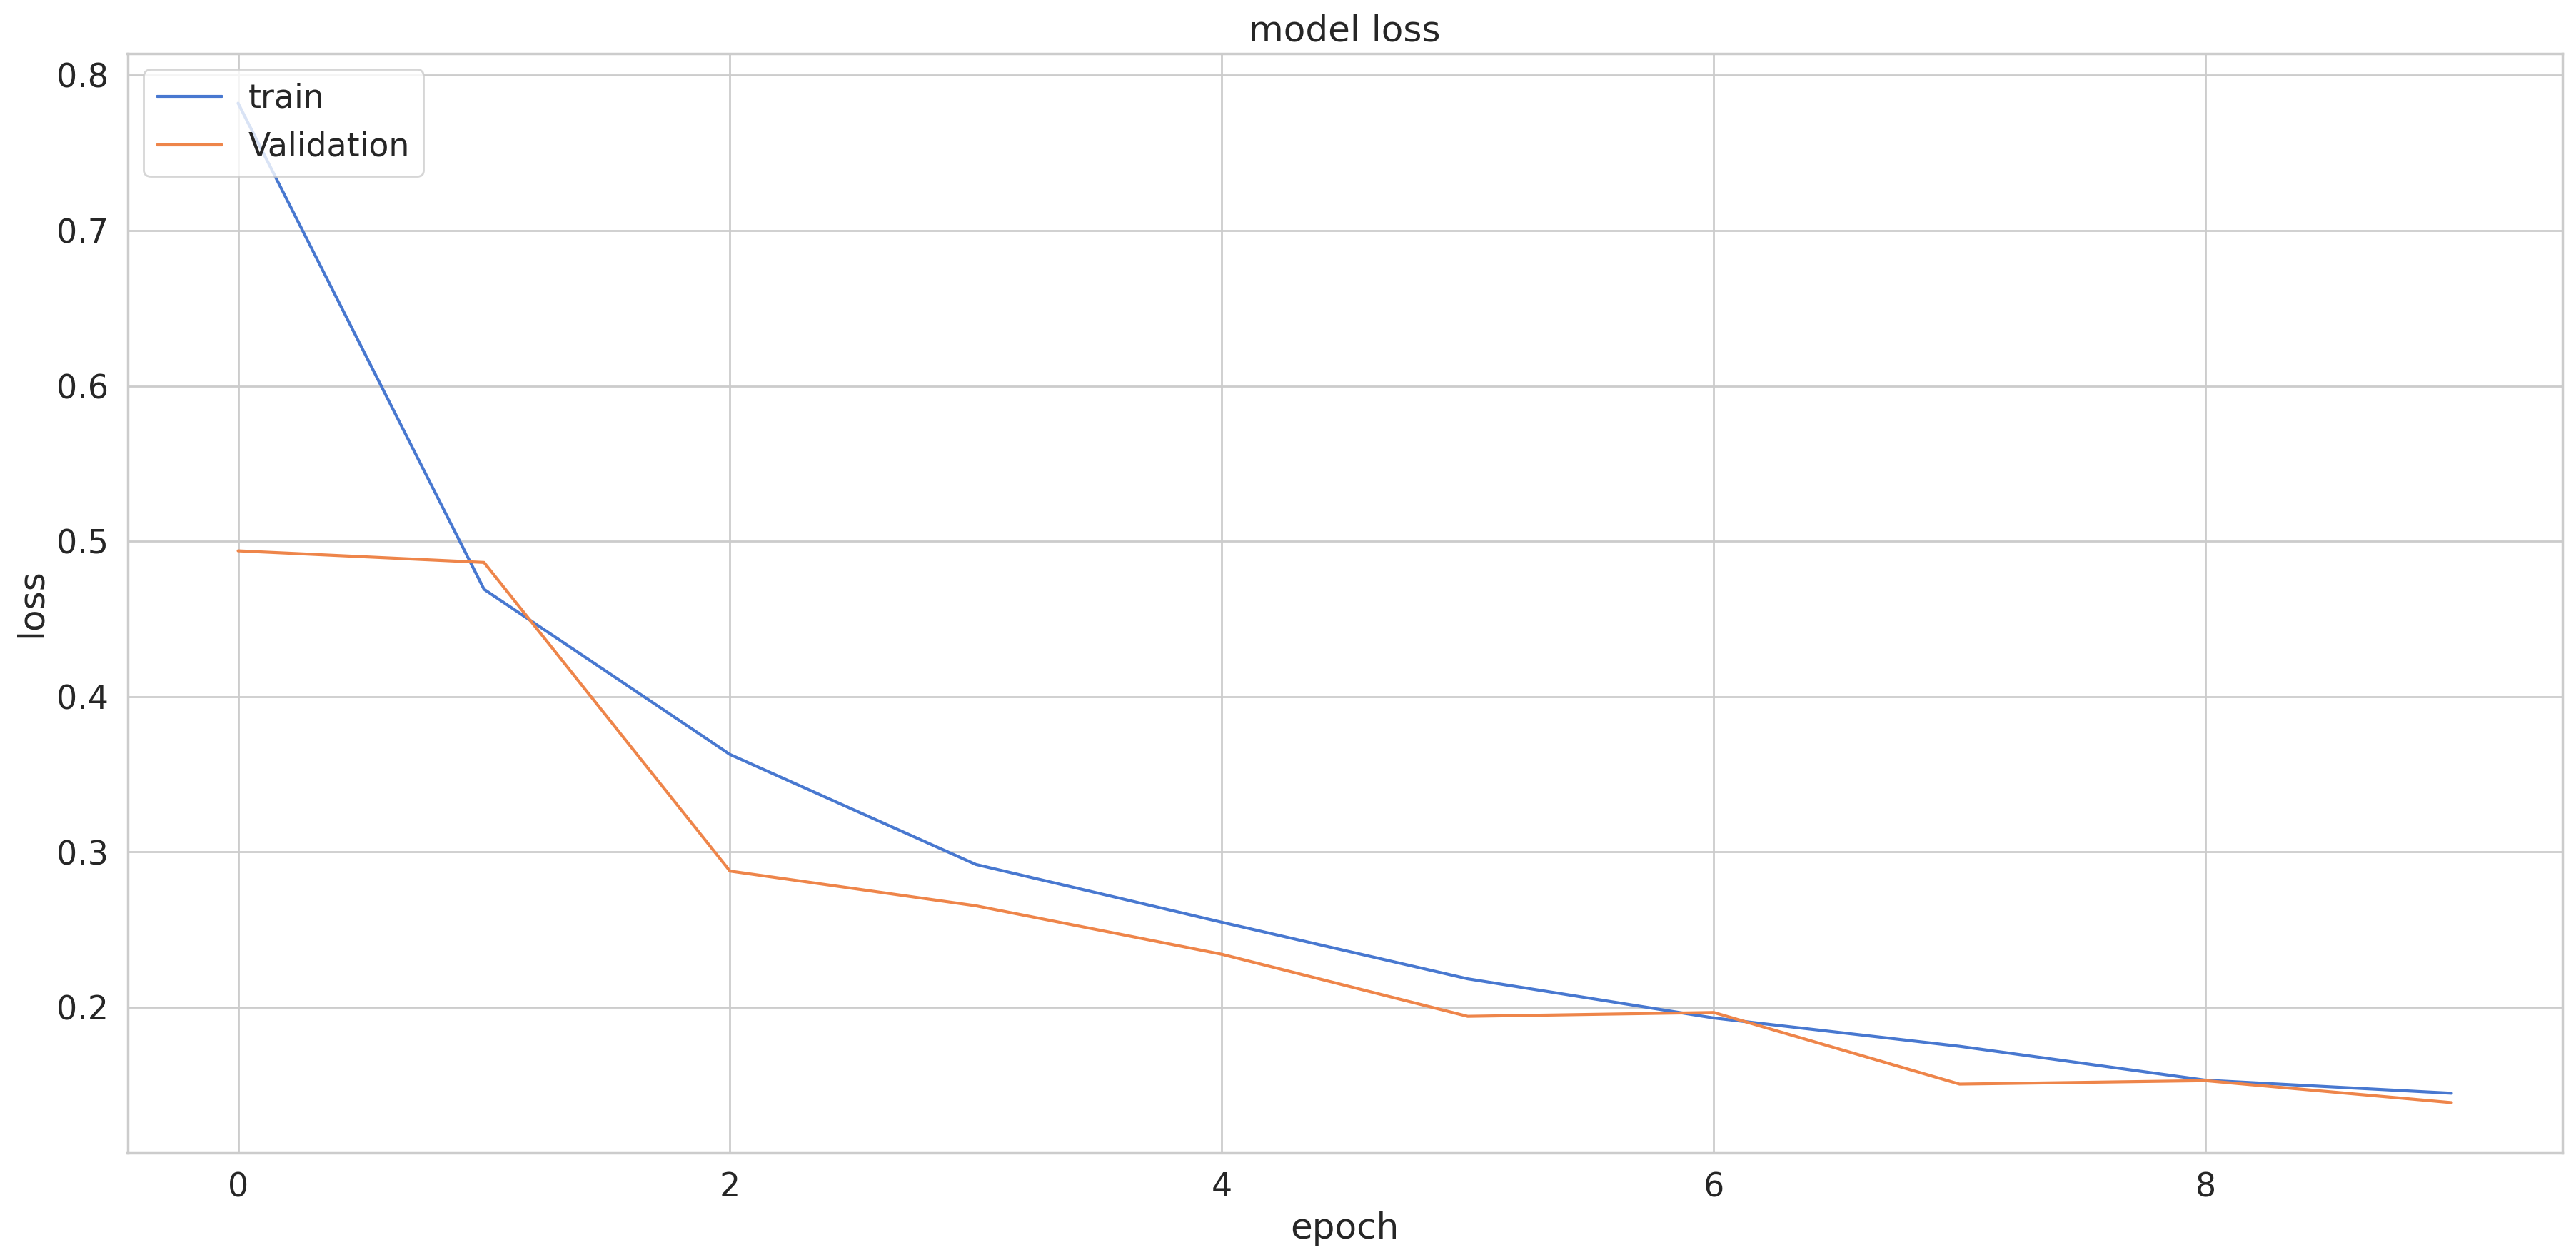

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

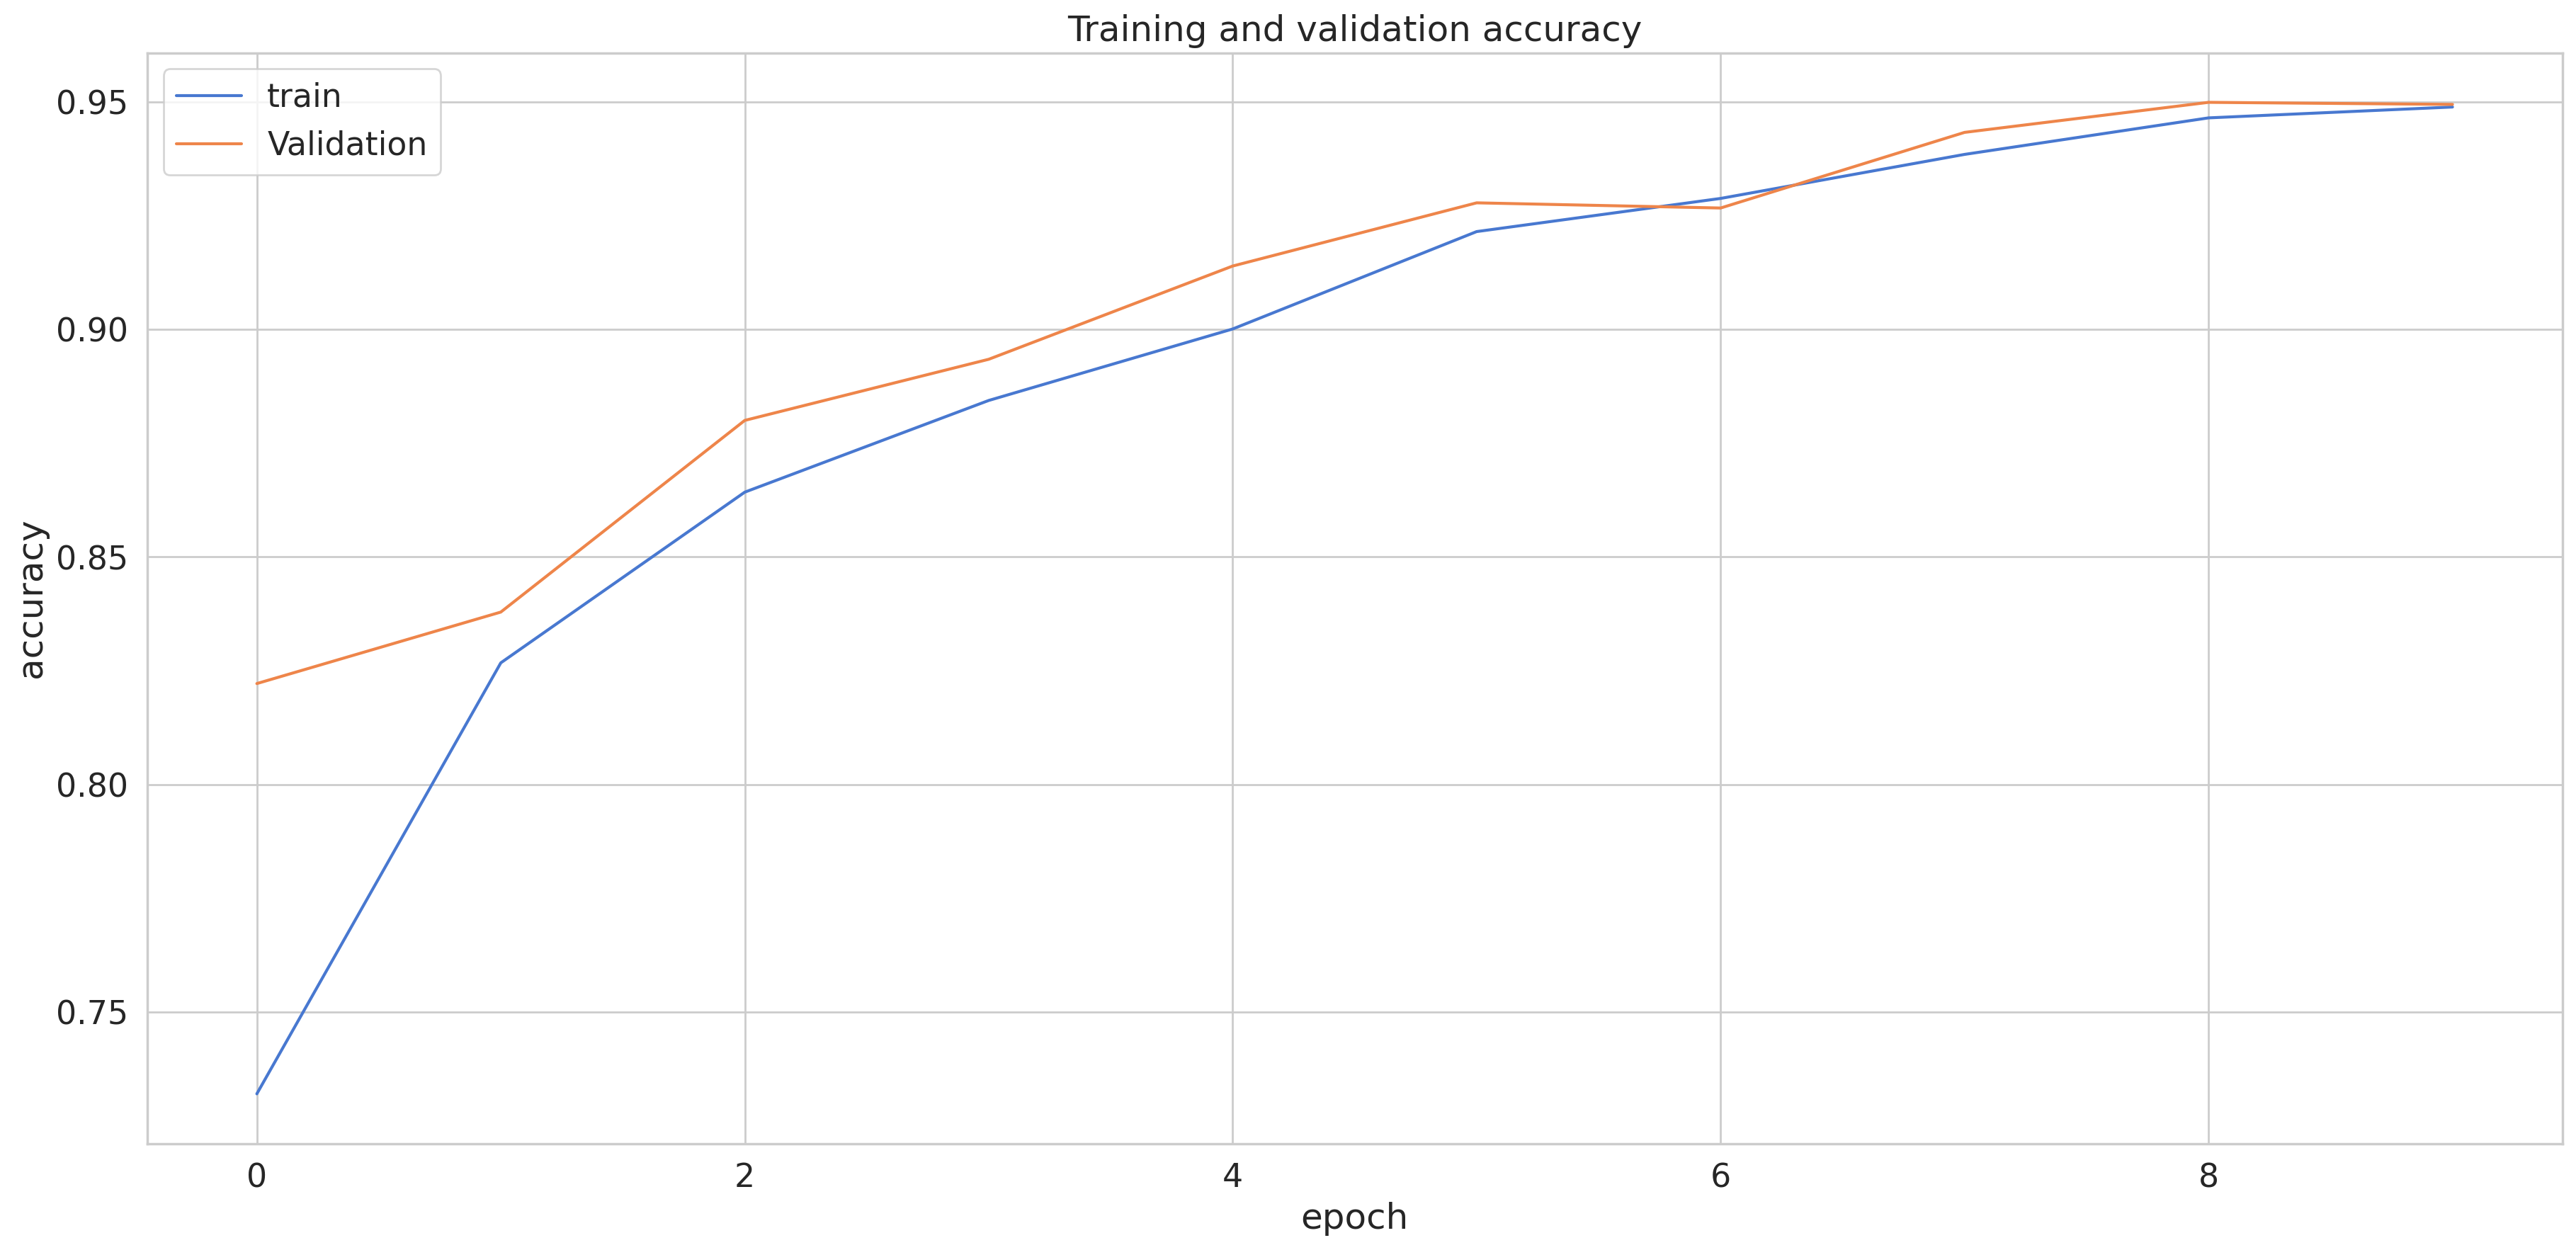

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

172/172 [==============================] - 5s 11ms/step
f1_score =  0.9453248805322017
0.9460936077217265
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2123
           1       0.96      0.99      0.97      1710
           2       0.86      0.73      0.79       614
           3       0.78      0.87      0.82       503
           4       0.99      0.97      0.98       300
           5       0.98      0.99      0.98       241

    accuracy                           0.95      5491
   macro avg       0.93      0.92      0.92      5491
weighted avg       0.95      0.95      0.95      5491



<Axes: >

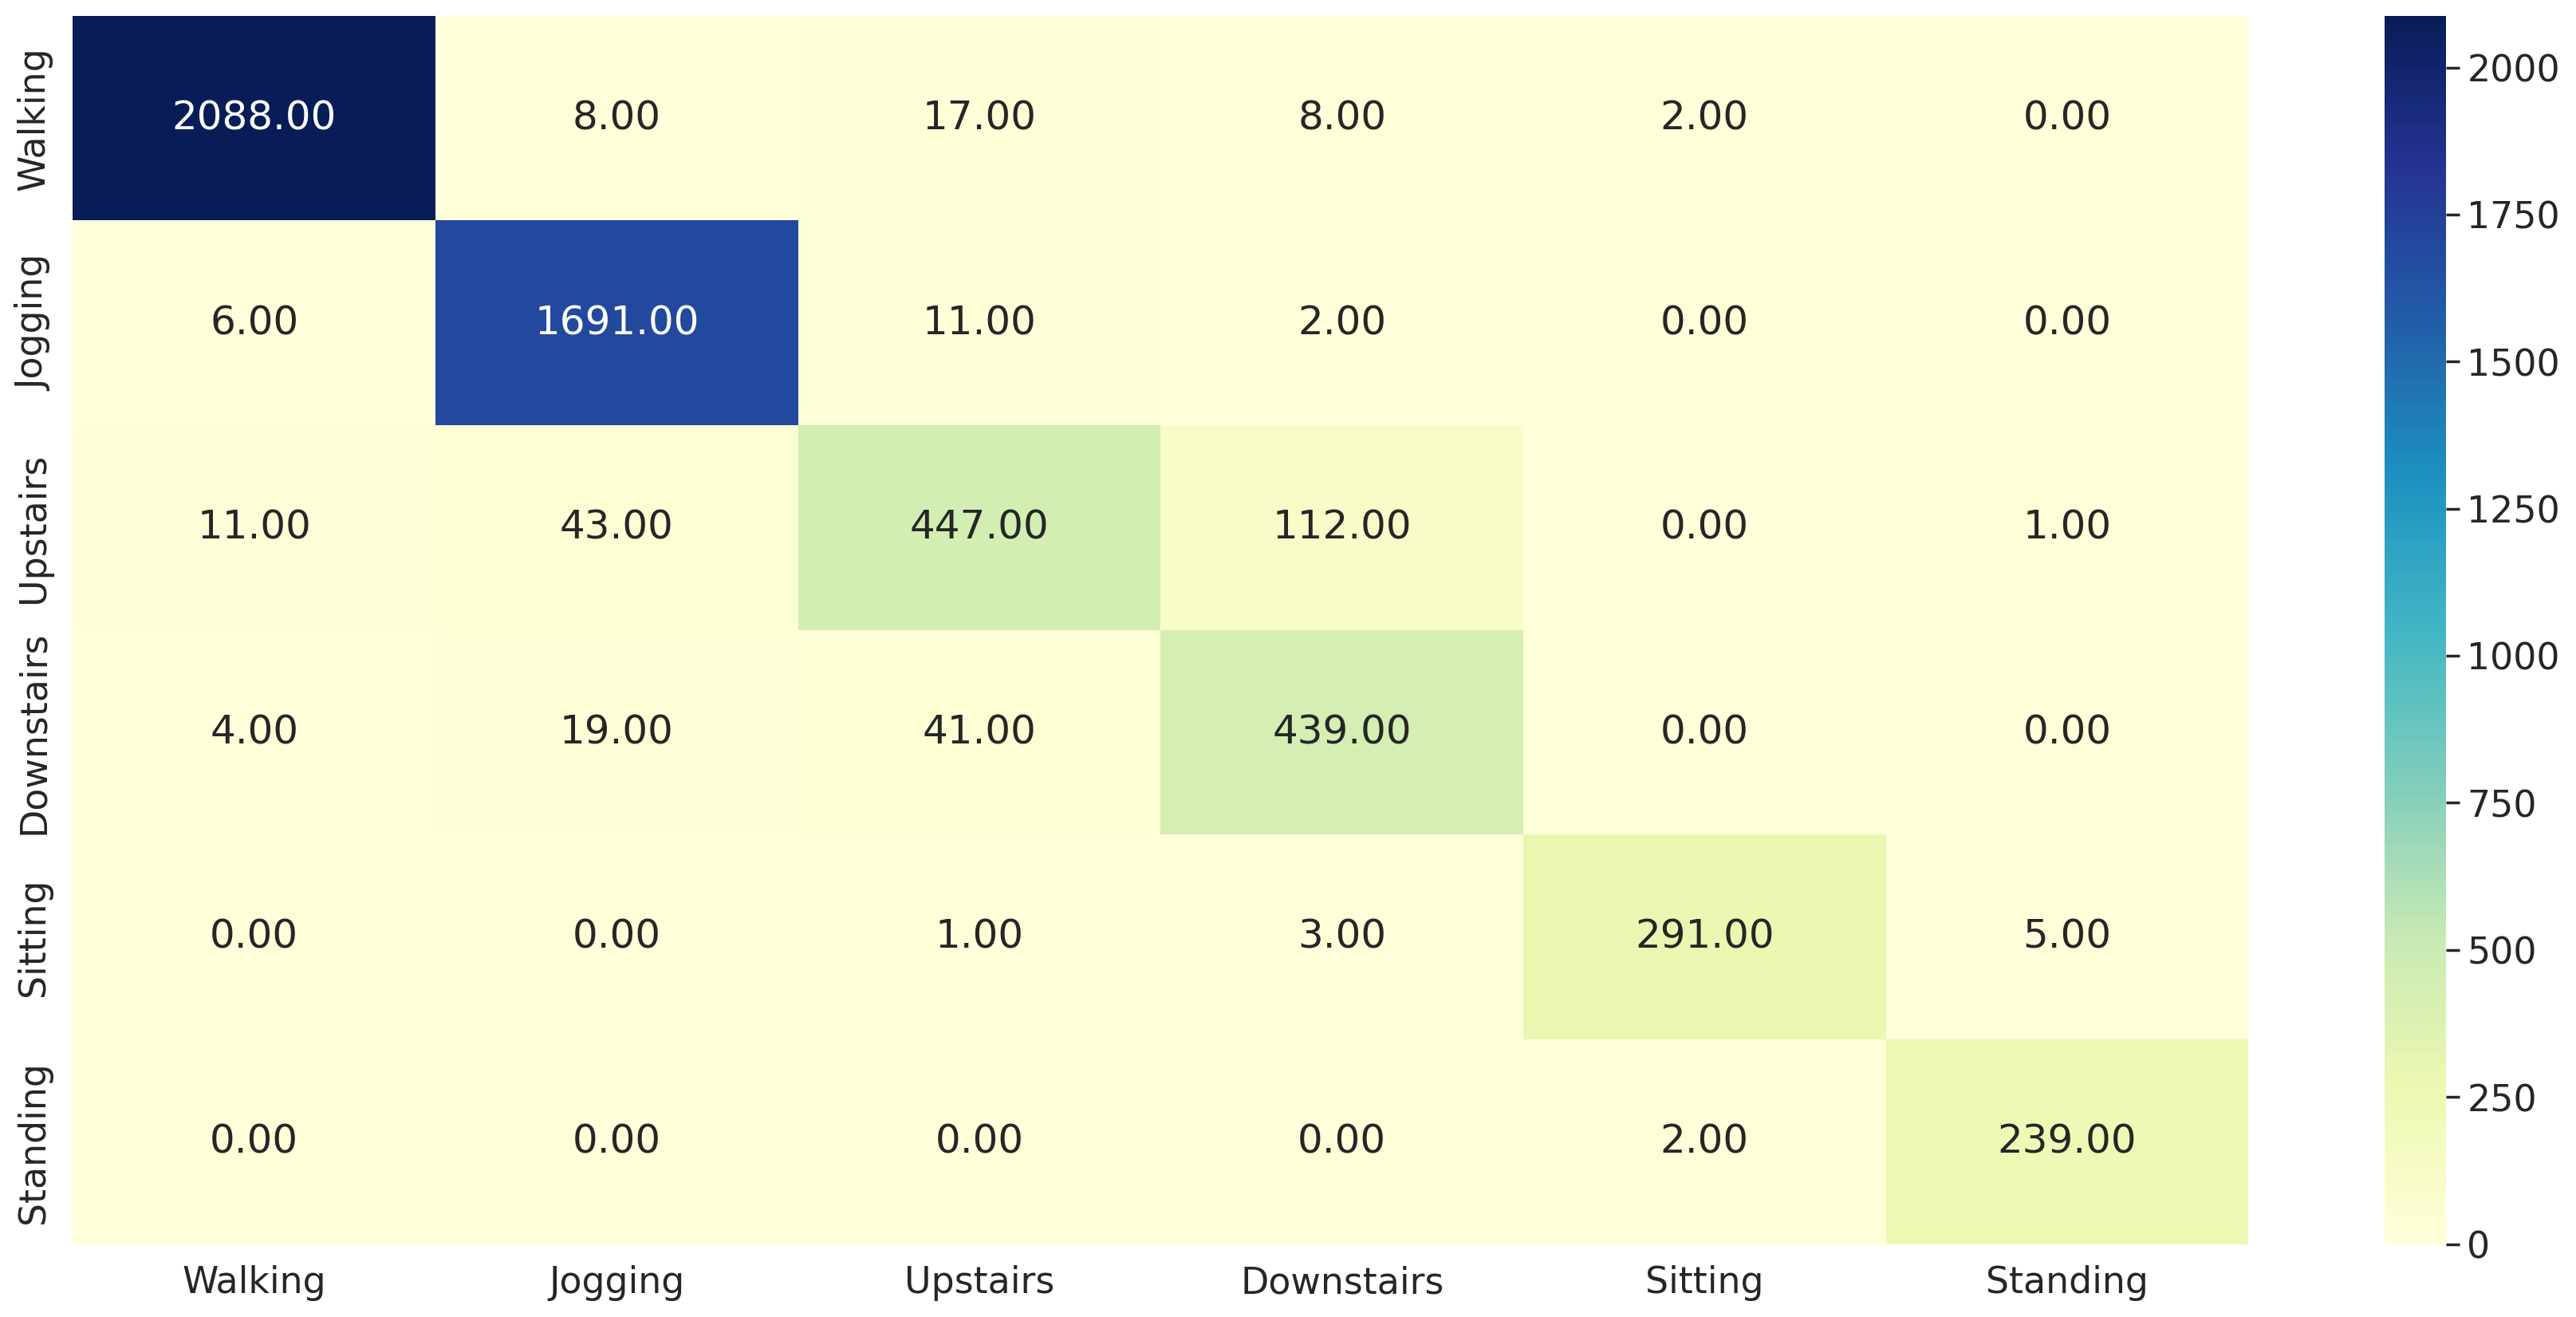

In [22]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM1

In [23]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, None, 48, 64)      640       
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, None, 46, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, None, 46, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, None, 23, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, None, 1472)       

In [24]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
138/138 [==============================] - 25s 162ms/step - loss: 0.7082 - accuracy: 0.7547 - val_loss: 0.3671 - val_accuracy: 0.8723
Epoch 2/10
138/138 [==============================] - 21s 151ms/step - loss: 0.3369 - accuracy: 0.8780 - val_loss: 0.2142 - val_accuracy: 0.9103
Epoch 3/10
138/138 [==============================] - 20s 148ms/step - loss: 0.2202 - accuracy: 0.9215 - val_loss: 0.1340 - val_accuracy: 0.9501
Epoch 4/10
138/138 [==============================] - 29s 210ms/step - loss: 0.1603 - accuracy: 0.9425 - val_loss: 0.1256 - val_accuracy: 0.9520
Epoch 5/10
138/138 [==============================] - 21s 152ms/step - loss: 0.1213 - accuracy: 0.9588 - val_loss: 0.1307 - val_accuracy: 0.9536
Epoch 6/10
138/138 [==============================] - 22s 159ms/step - loss: 0.0992 - accuracy: 0.9652 - val_loss: 0.1000 - val_accuracy: 0.9661
Epoch 7/10
138/138 [==============================] - 20s 148ms/step - loss: 0.0821 - accuracy: 0.9722 - val_loss: 0.0911 - val_ac

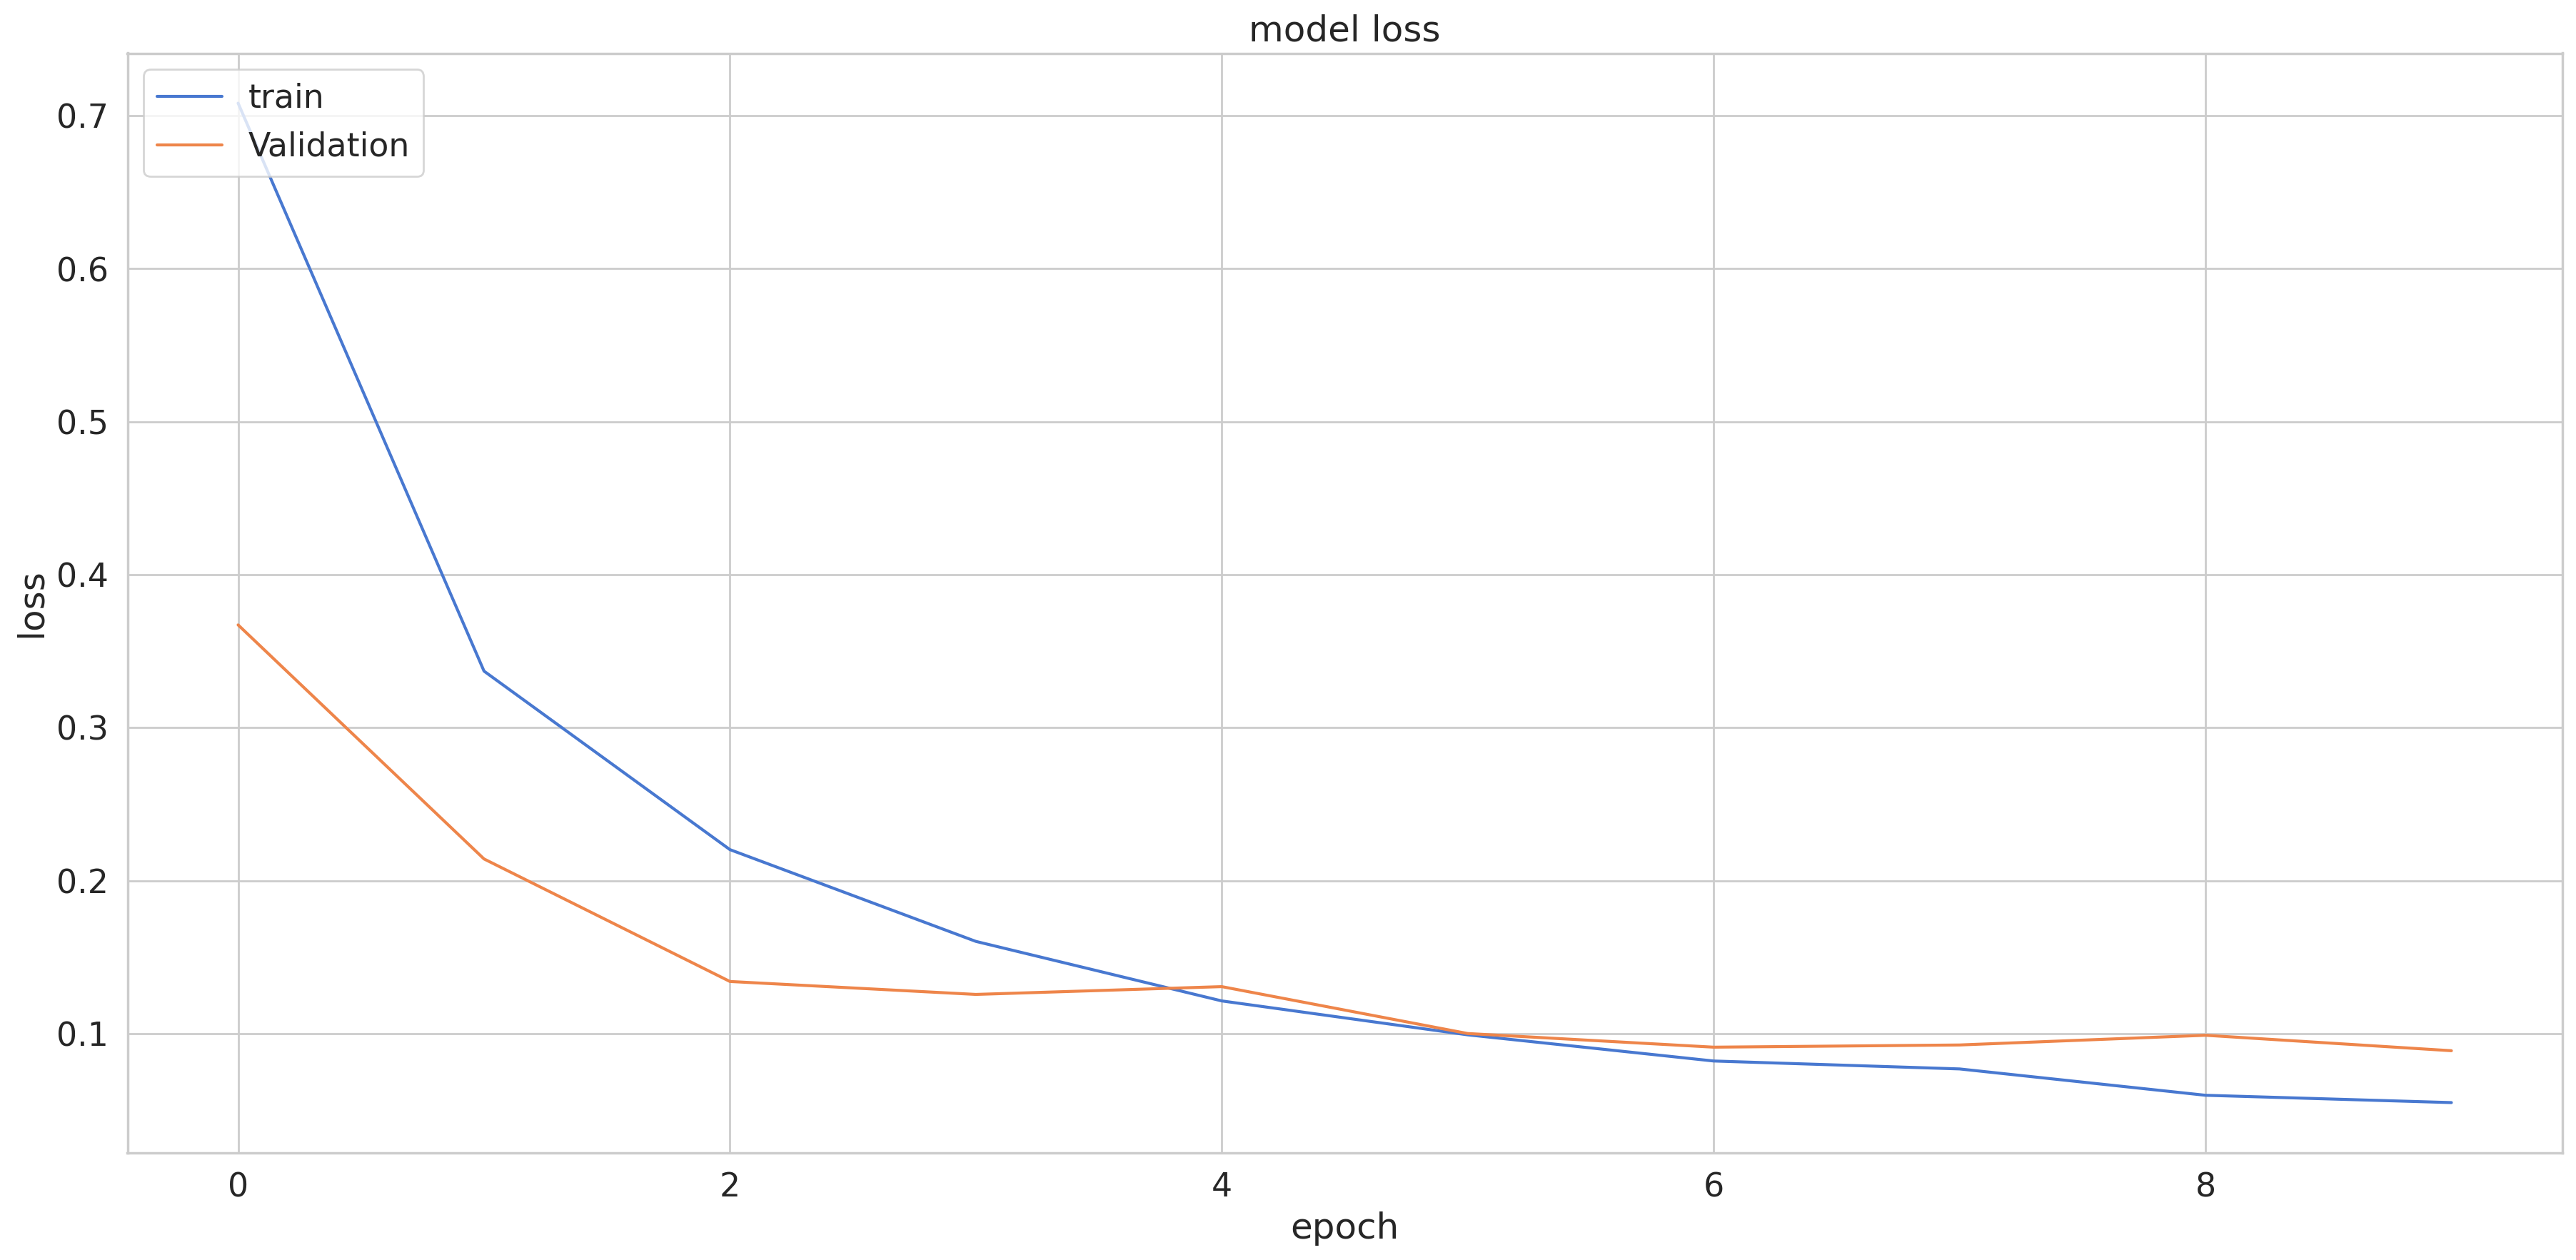

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

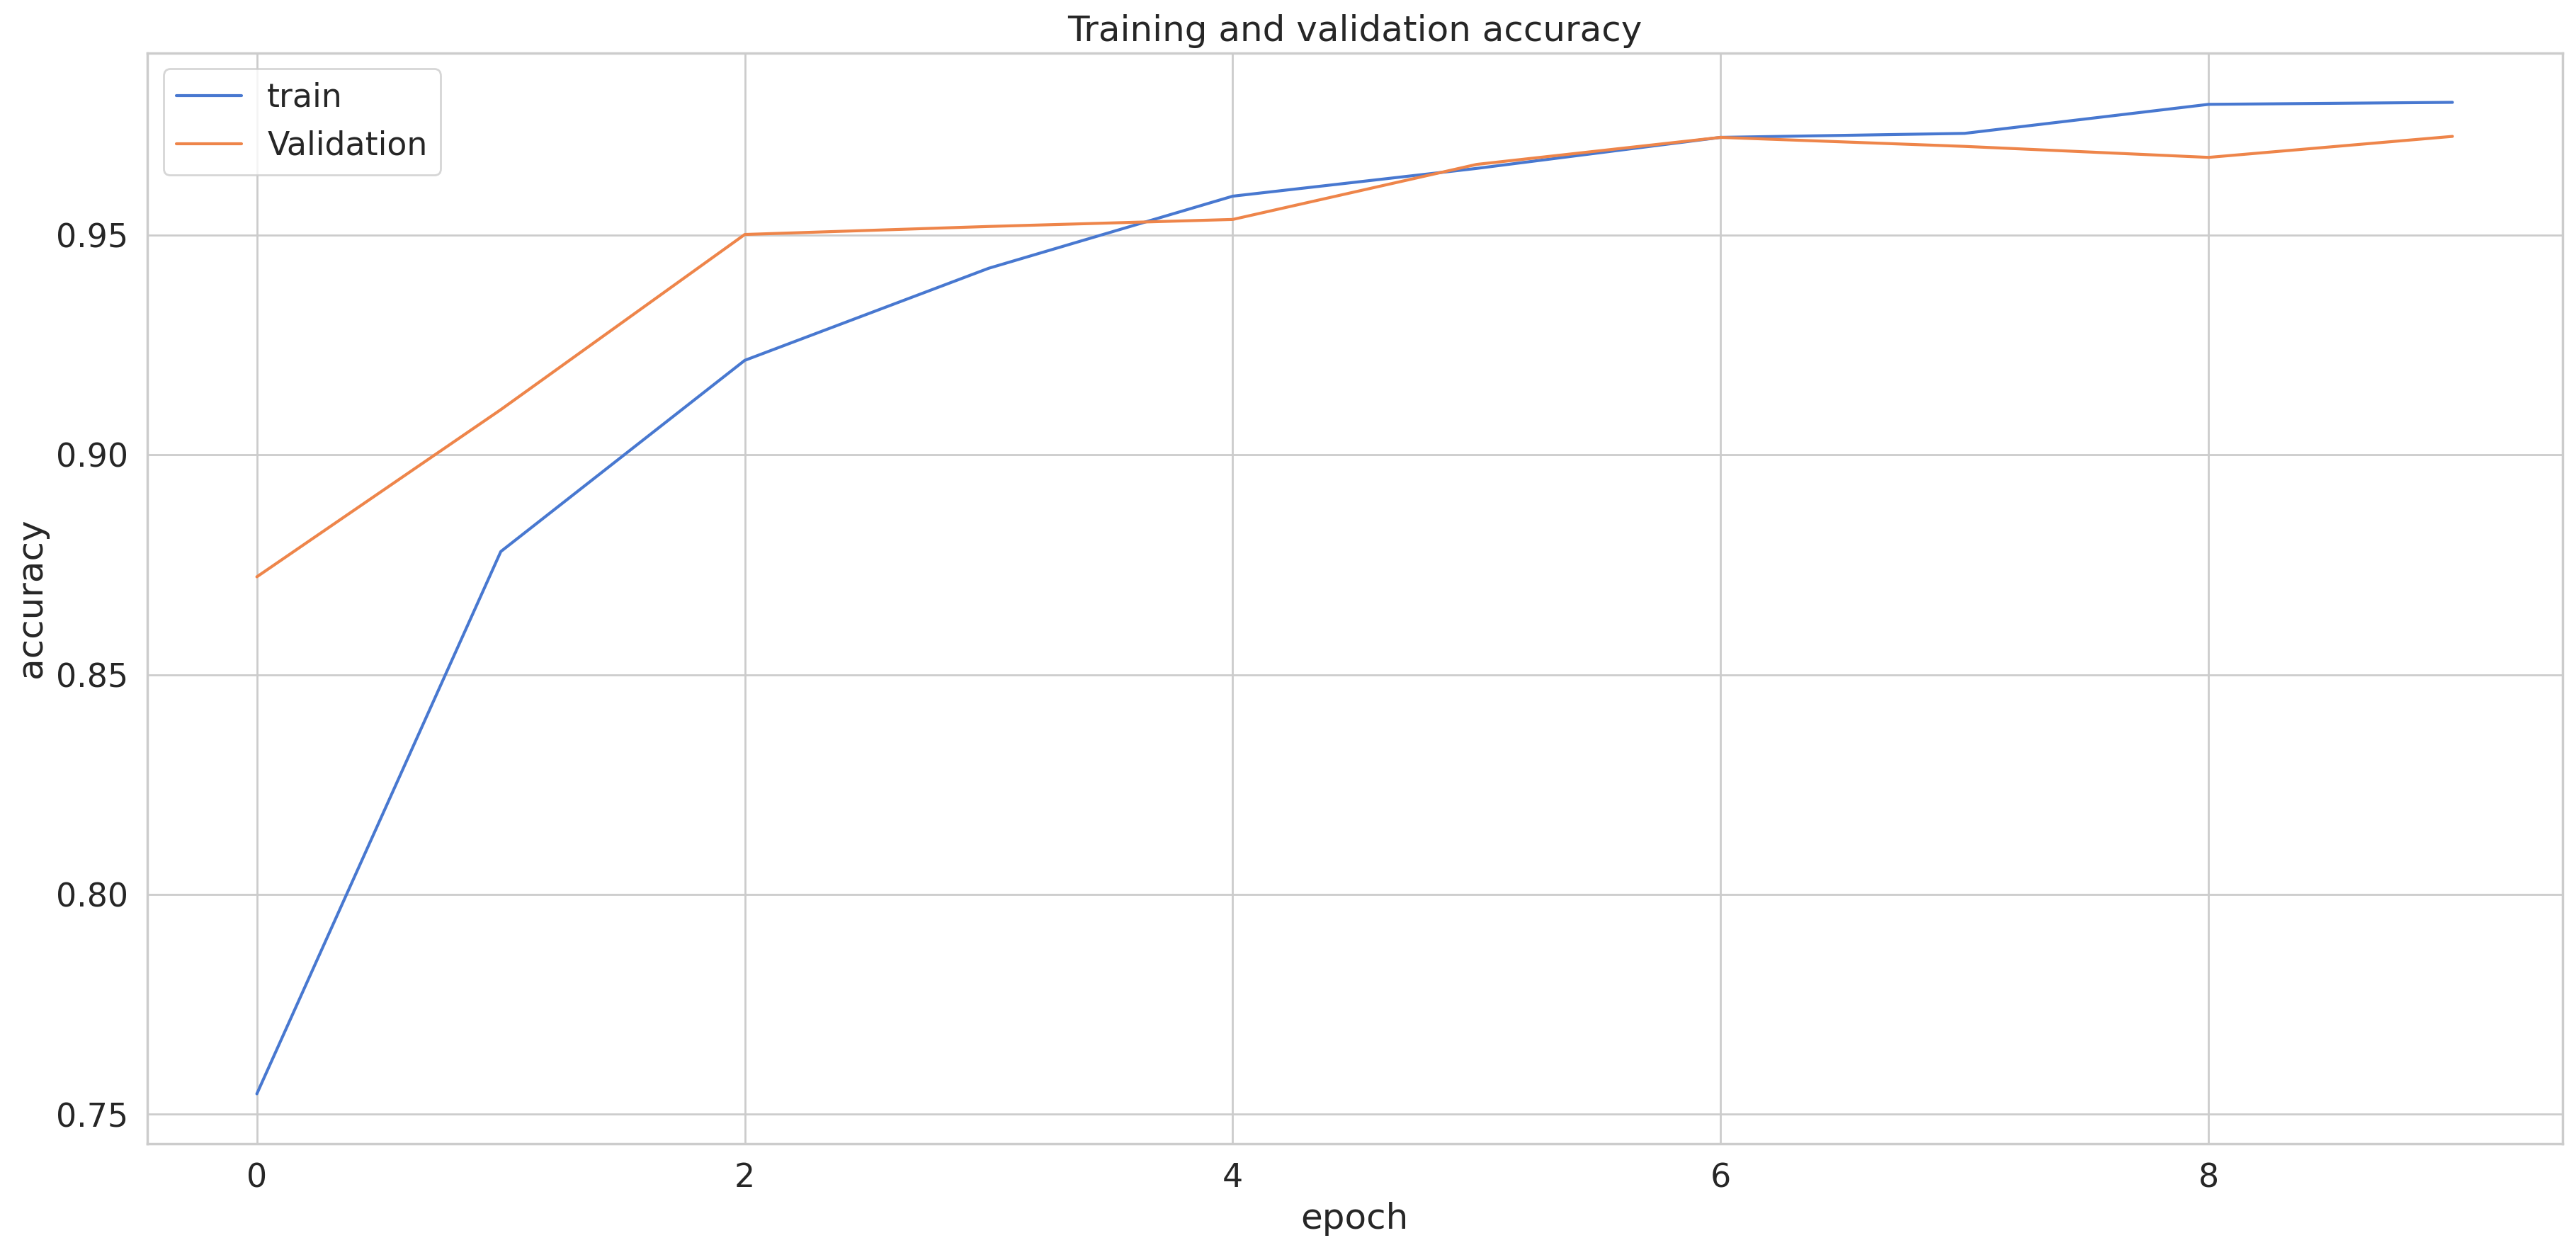

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

172/172 [==============================] - 3s 13ms/step
f1_score =  0.969103701204591
0.9688581314878892
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2123
           1       0.99      0.98      0.99      1710
           2       0.90      0.92      0.91       614
           3       0.89      0.92      0.91       503
           4       0.97      0.97      0.97       300
           5       0.95      0.96      0.96       241

    accuracy                           0.97      5491
   macro avg       0.95      0.96      0.95      5491
weighted avg       0.97      0.97      0.97      5491



<Axes: >

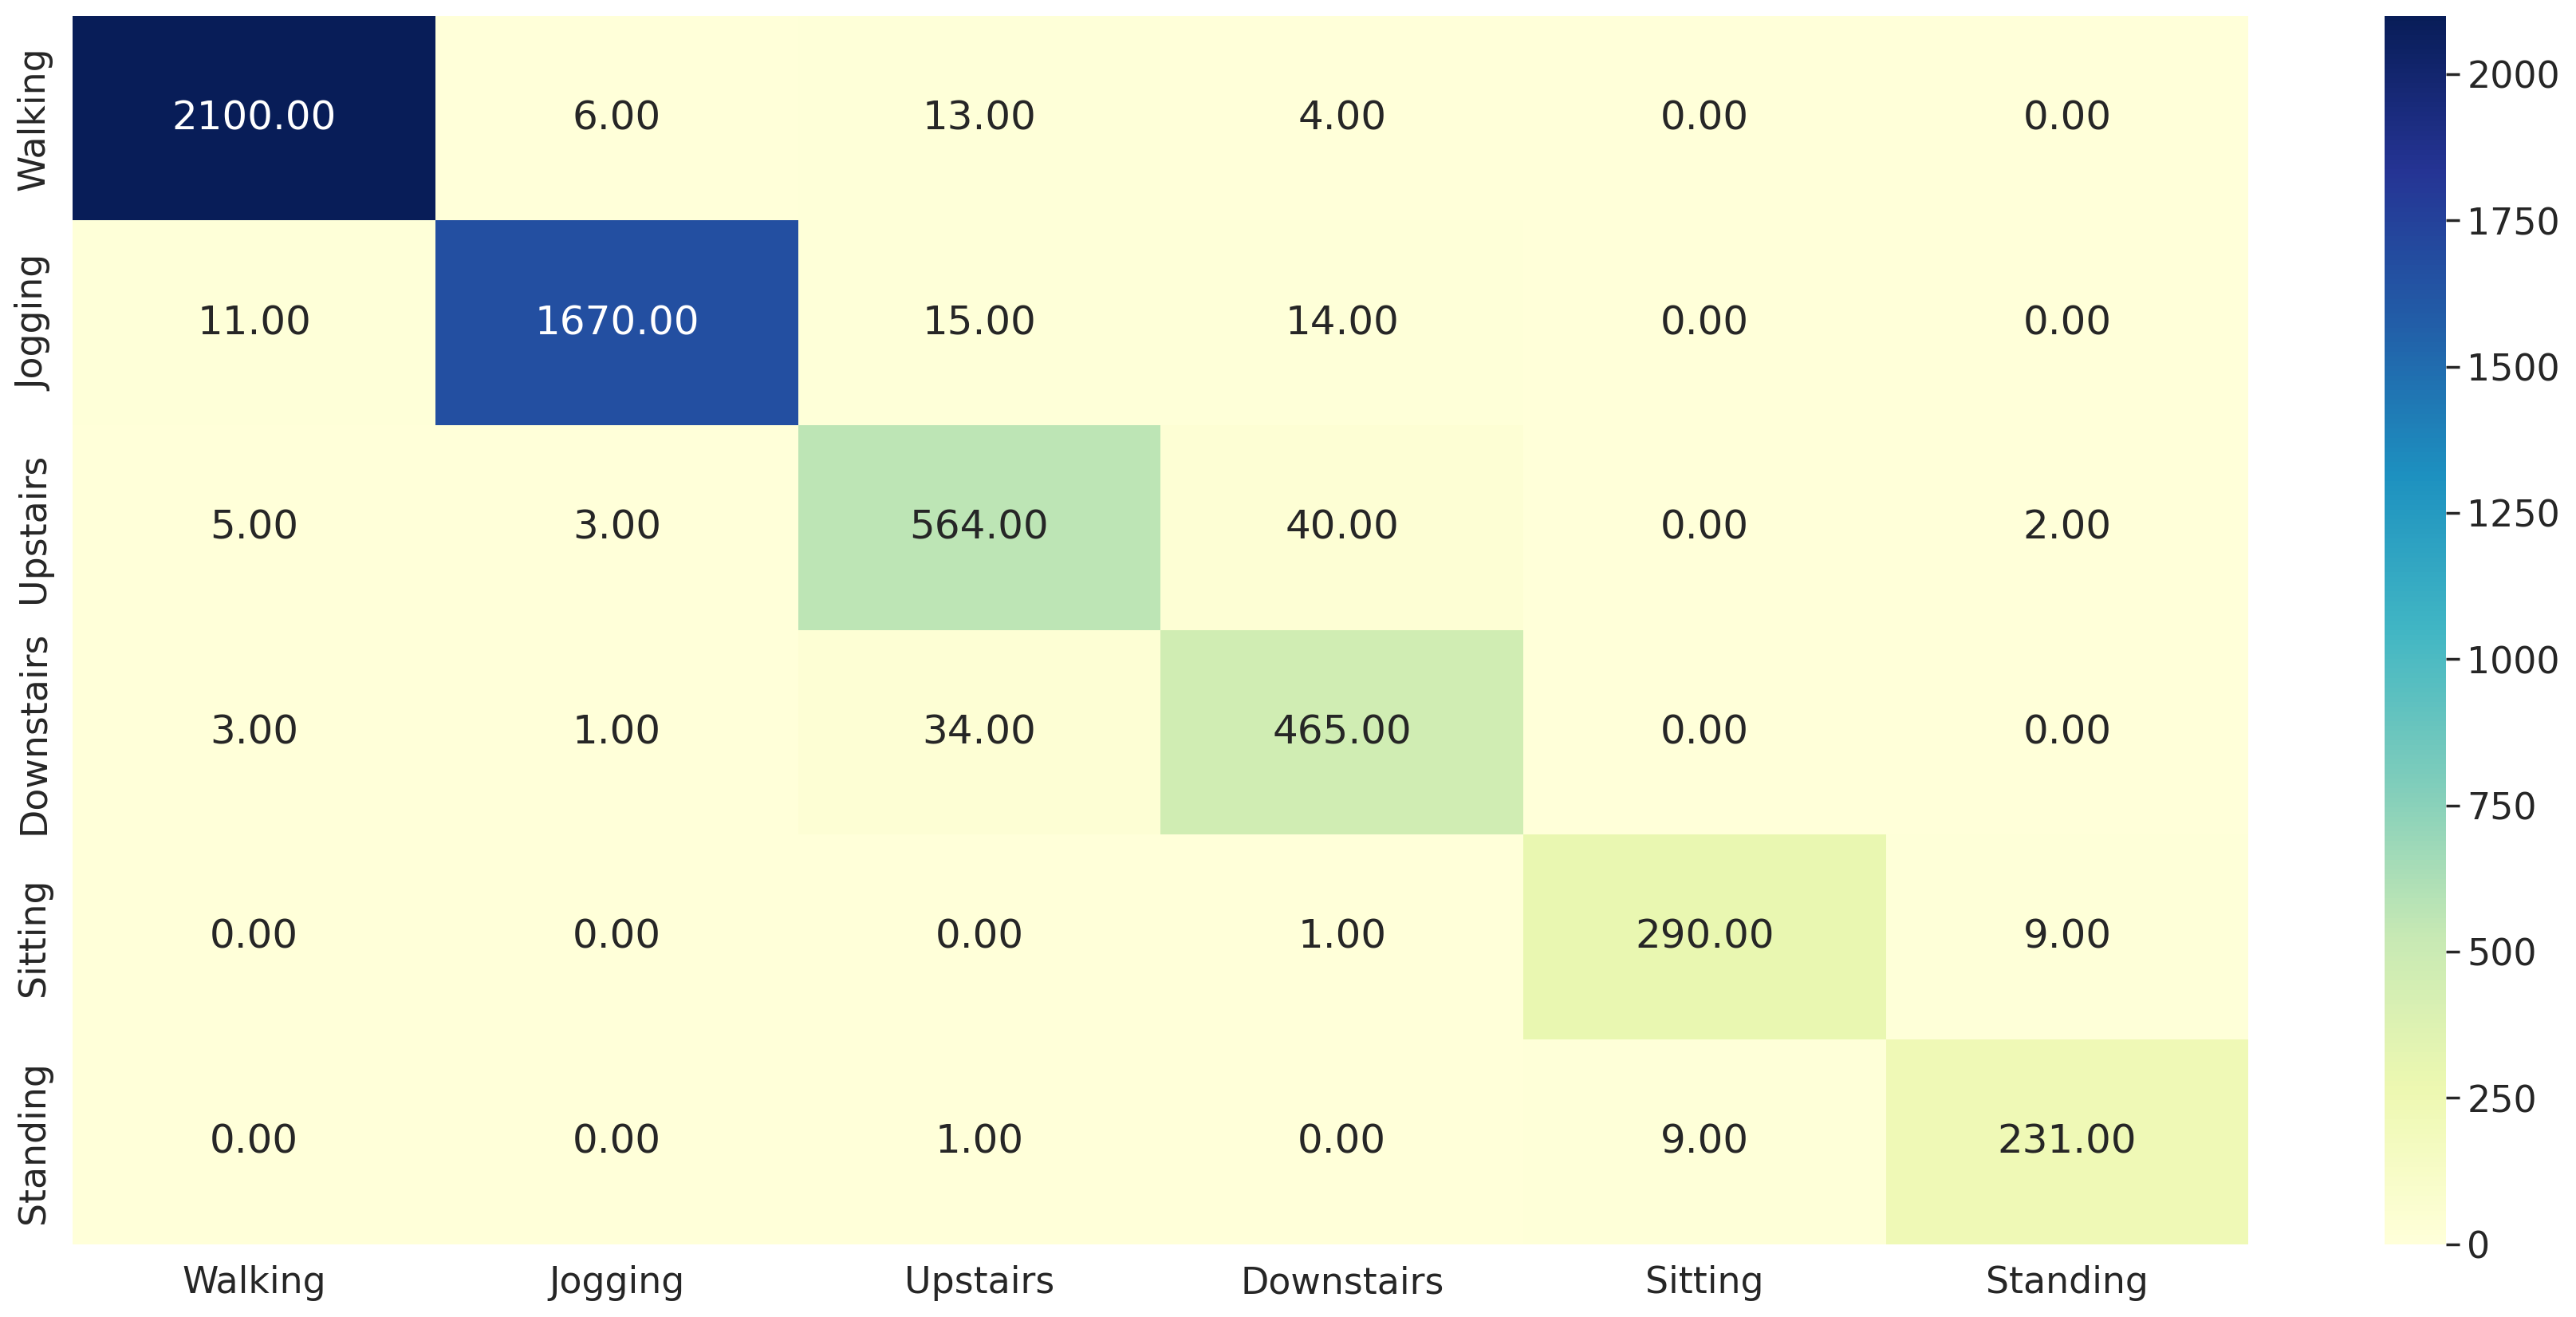

In [27]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM2

In [28]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeD  (None, None, 48, 64)      640       
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, None, 46, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, None, 46, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, None, 23, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, None, 1472)       

In [29]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
138/138 [==============================] - 34s 201ms/step - loss: 0.7429 - accuracy: 0.7459 - val_loss: 0.3876 - val_accuracy: 0.8427
Epoch 2/10
138/138 [==============================] - 25s 178ms/step - loss: 0.3311 - accuracy: 0.8703 - val_loss: 0.2323 - val_accuracy: 0.9076
Epoch 3/10
138/138 [==============================] - 24s 174ms/step - loss: 0.2217 - accuracy: 0.9146 - val_loss: 0.1893 - val_accuracy: 0.9251
Epoch 4/10
138/138 [==============================] - 23s 167ms/step - loss: 0.1584 - accuracy: 0.9423 - val_loss: 0.1379 - val_accuracy: 0.9536
Epoch 5/10
138/138 [==============================] - 25s 184ms/step - loss: 0.1289 - accuracy: 0.9550 - val_loss: 0.1462 - val_accuracy: 0.9479
Epoch 6/10
138/138 [==============================] - 23s 165ms/step - loss: 0.0989 - accuracy: 0.9675 - val_loss: 0.1063 - val_accuracy: 0.9643
Epoch 7/10
138/138 [==============================] - 24s 177ms/step - loss: 0.0876 - accuracy: 0.9693 - val_loss: 0.0746 - val_ac

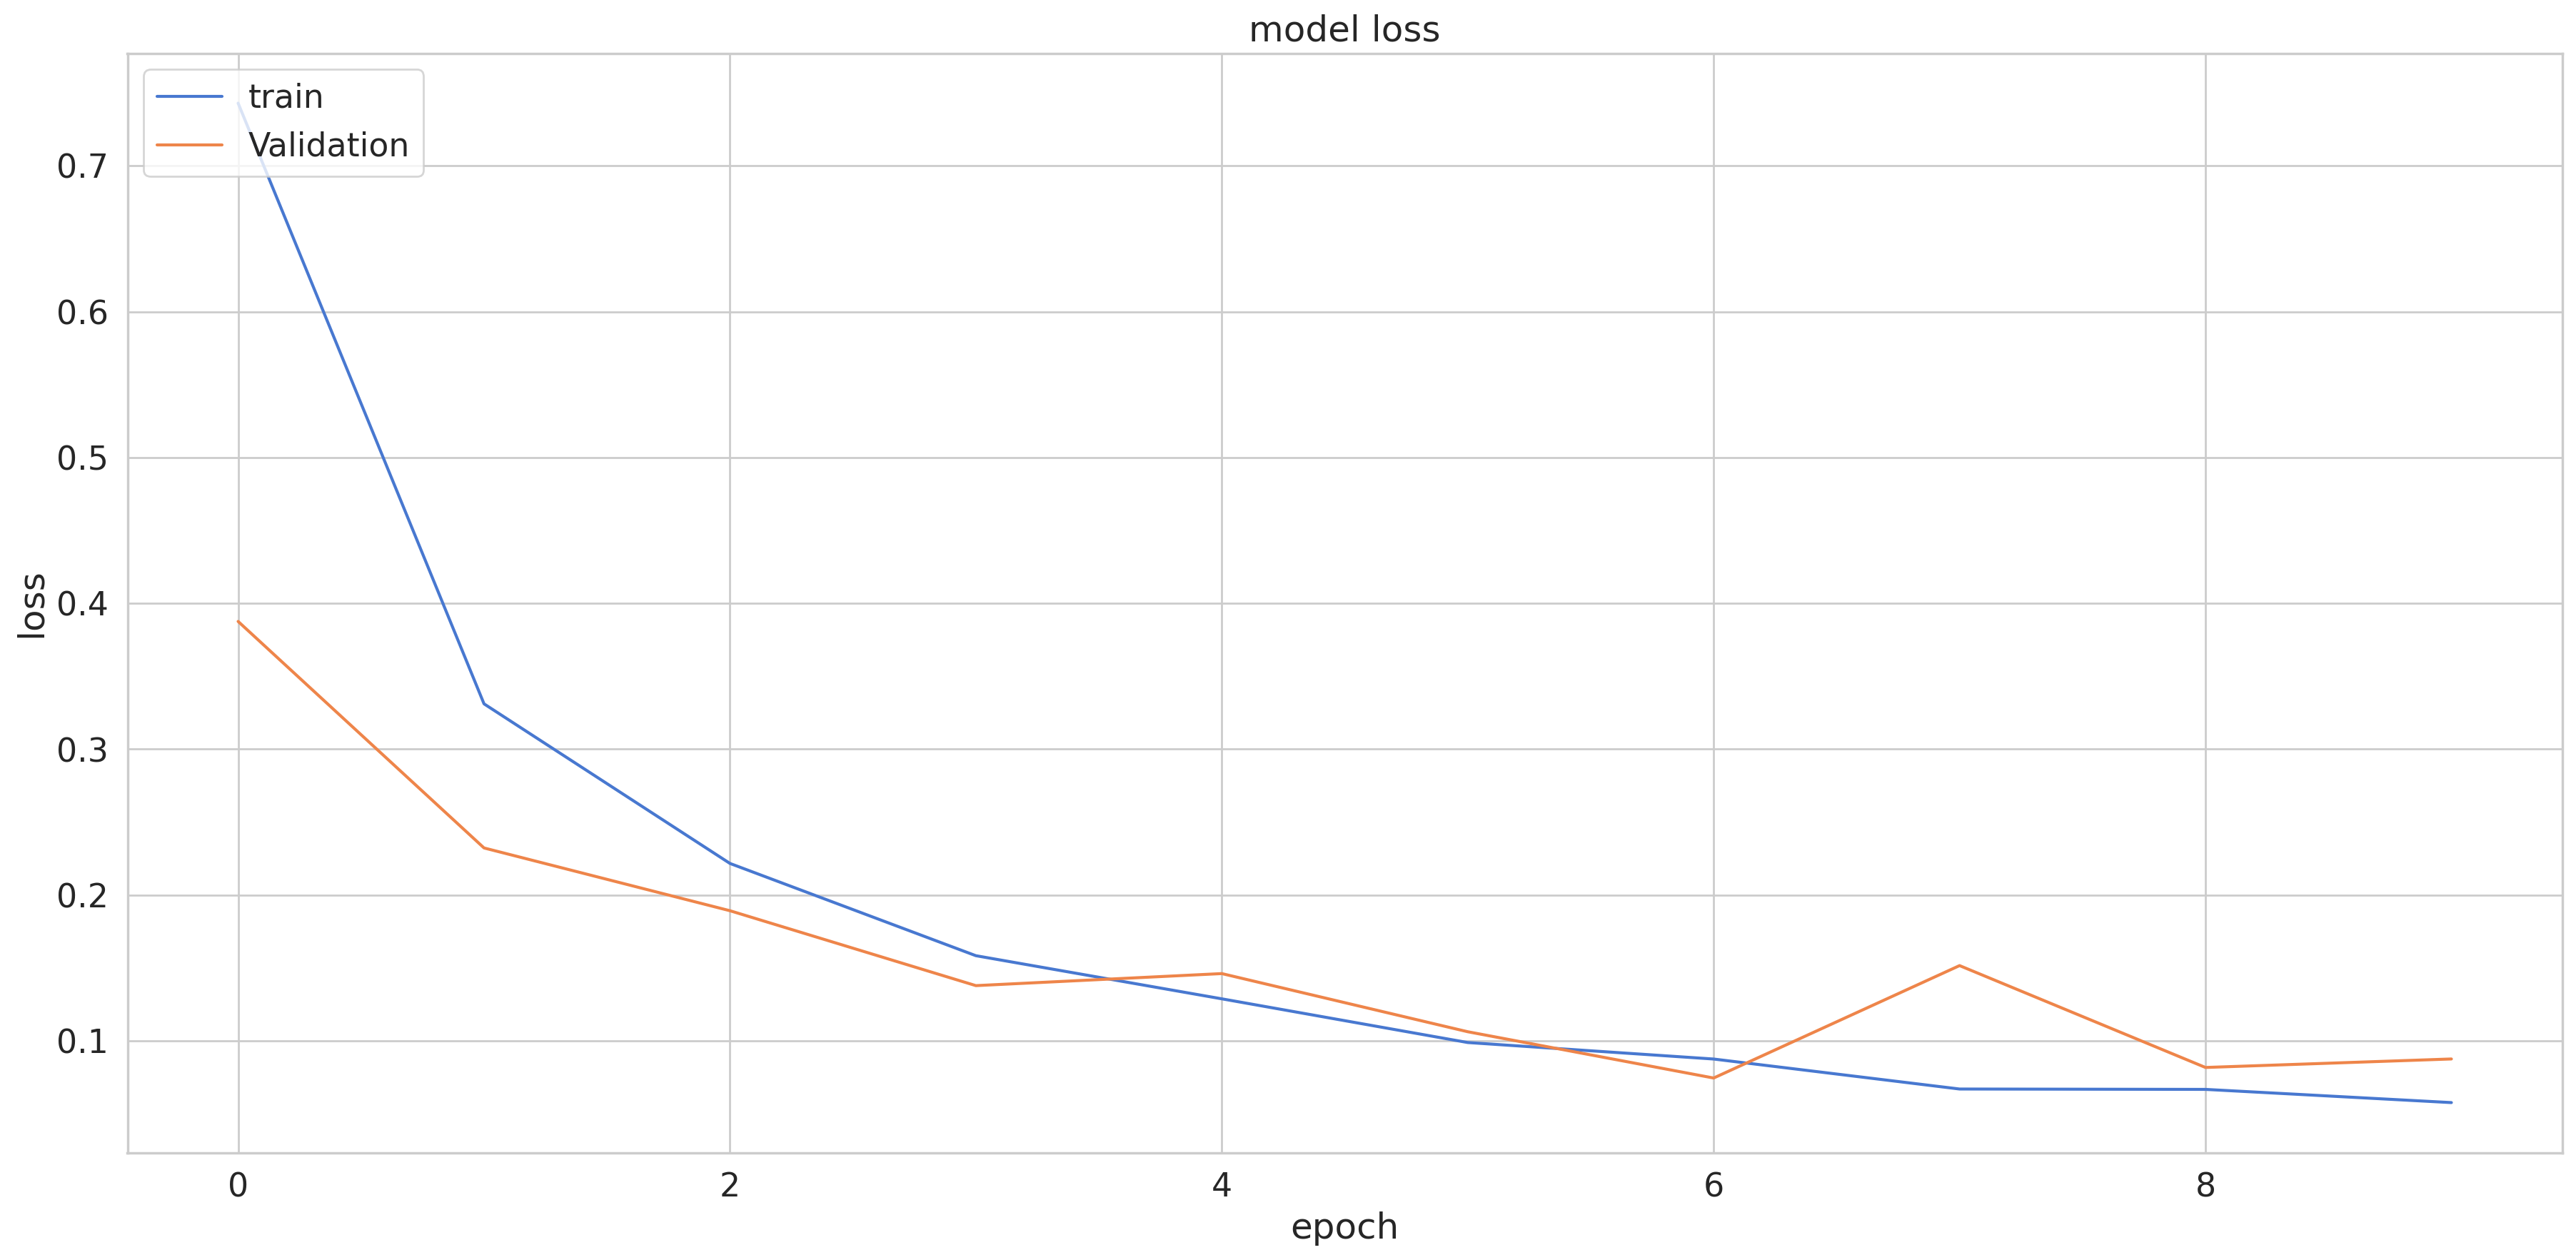

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

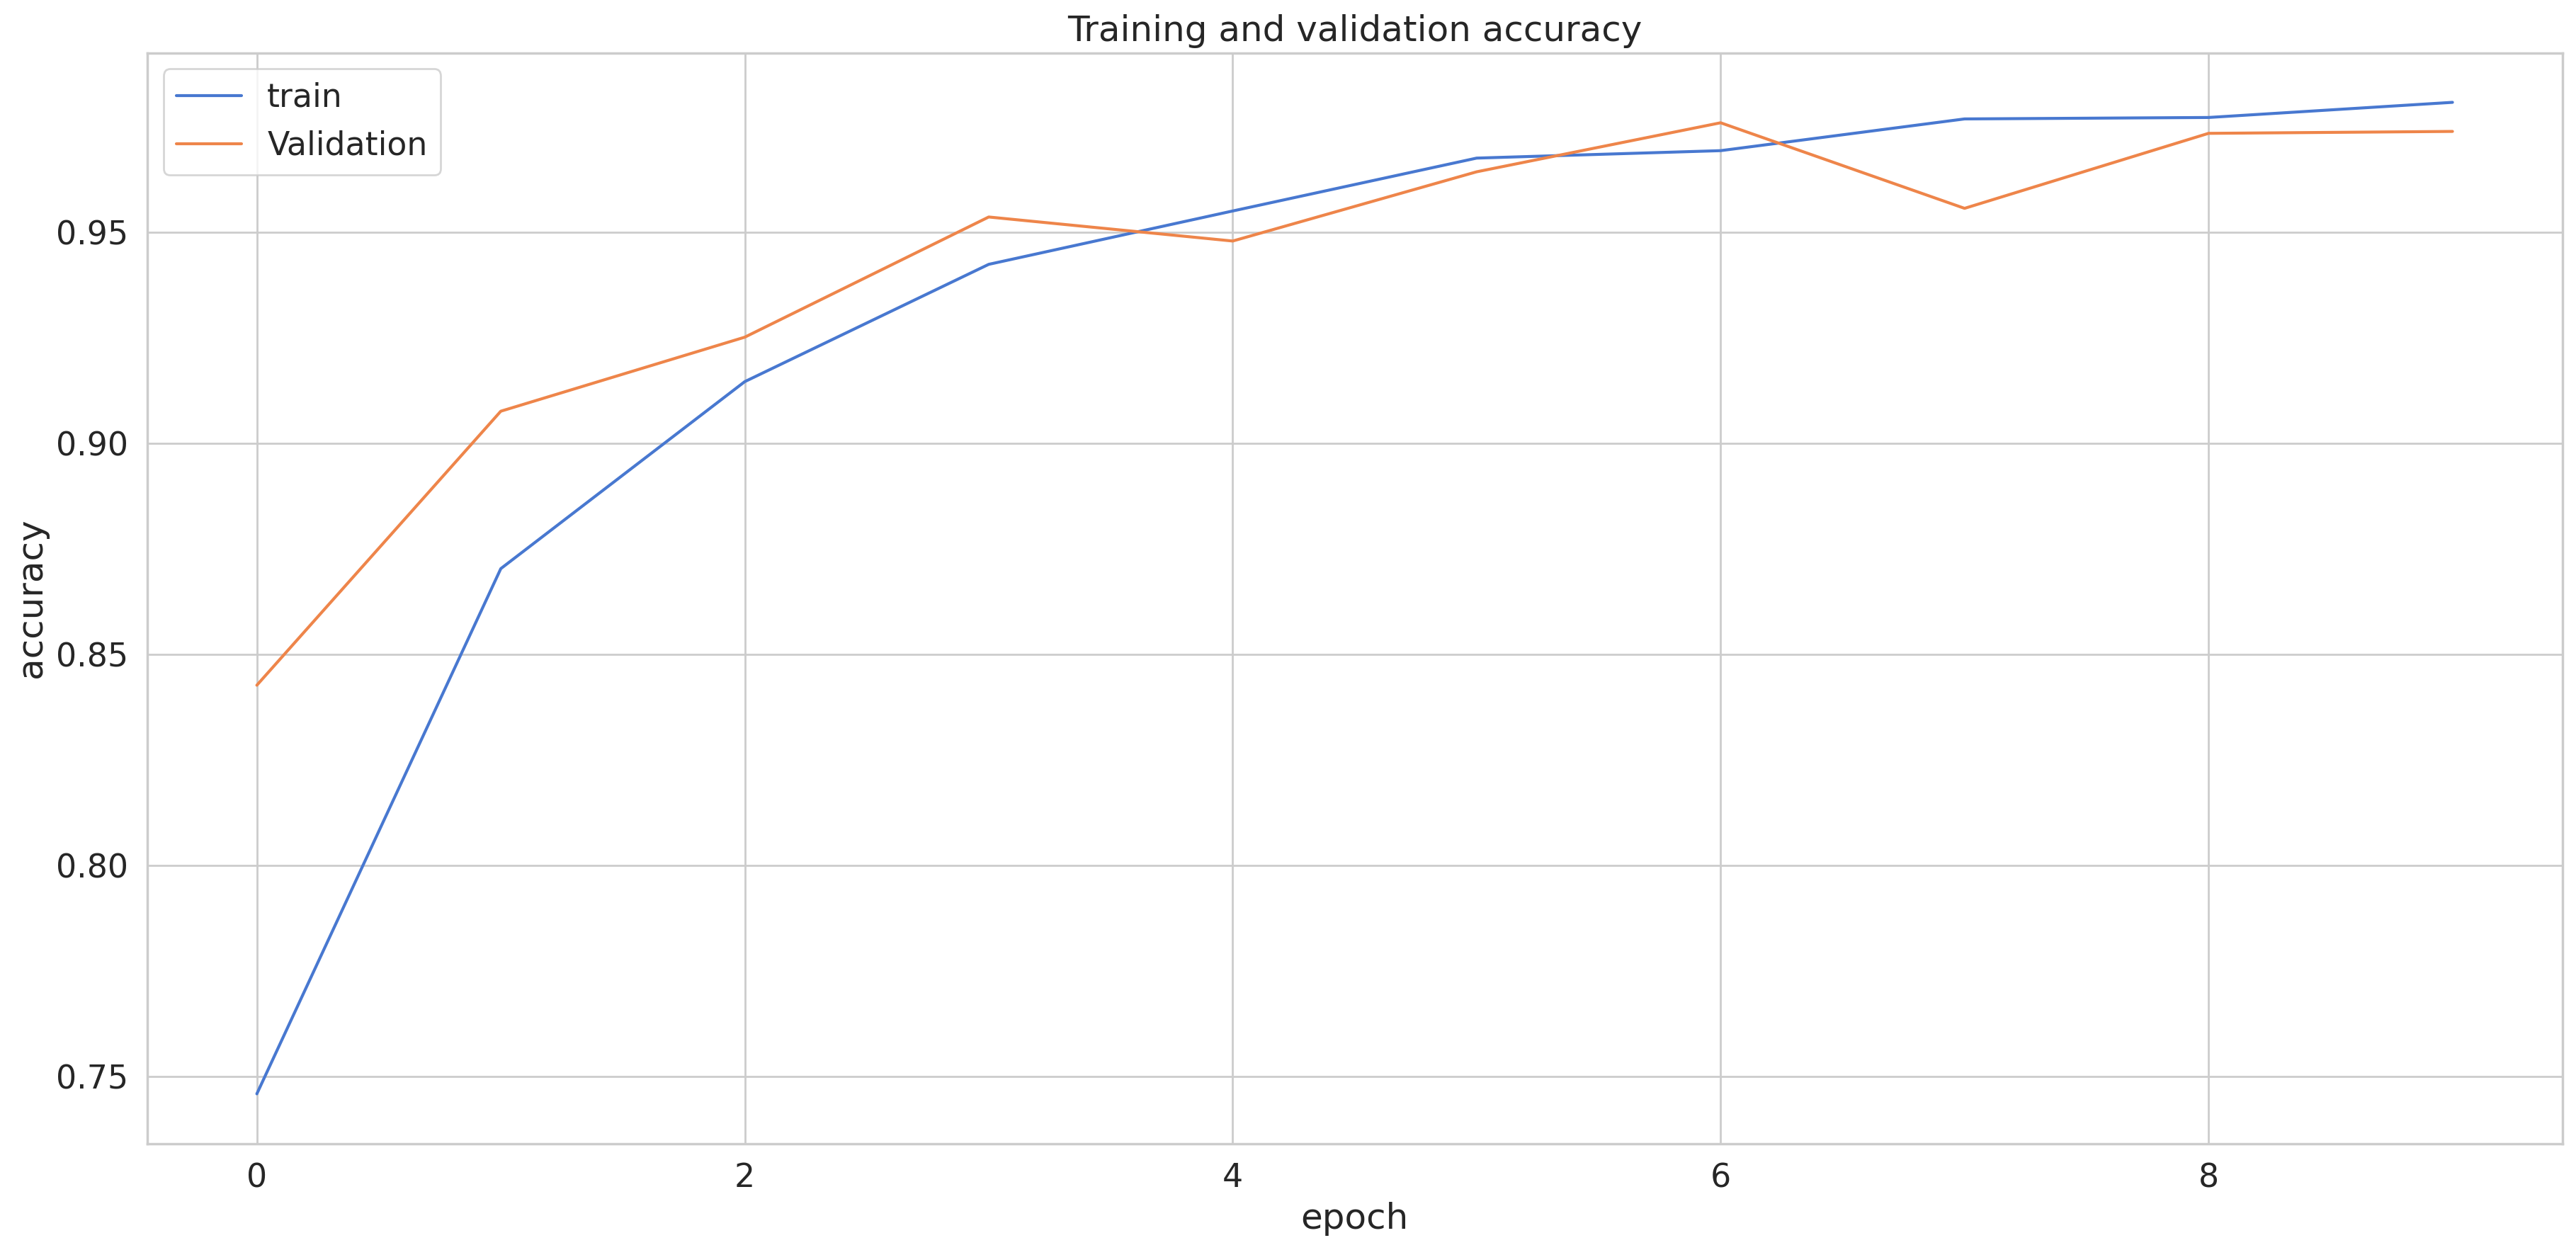

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

172/172 [==============================] - 5s 22ms/step
f1_score =  0.9718027173782622
0.9717719905299581
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2123
           1       0.99      0.99      0.99      1710
           2       0.93      0.87      0.90       614
           3       0.87      0.97      0.92       503
           4       0.99      0.96      0.98       300
           5       0.96      0.98      0.97       241

    accuracy                           0.97      5491
   macro avg       0.96      0.96      0.96      5491
weighted avg       0.97      0.97      0.97      5491



<Axes: >

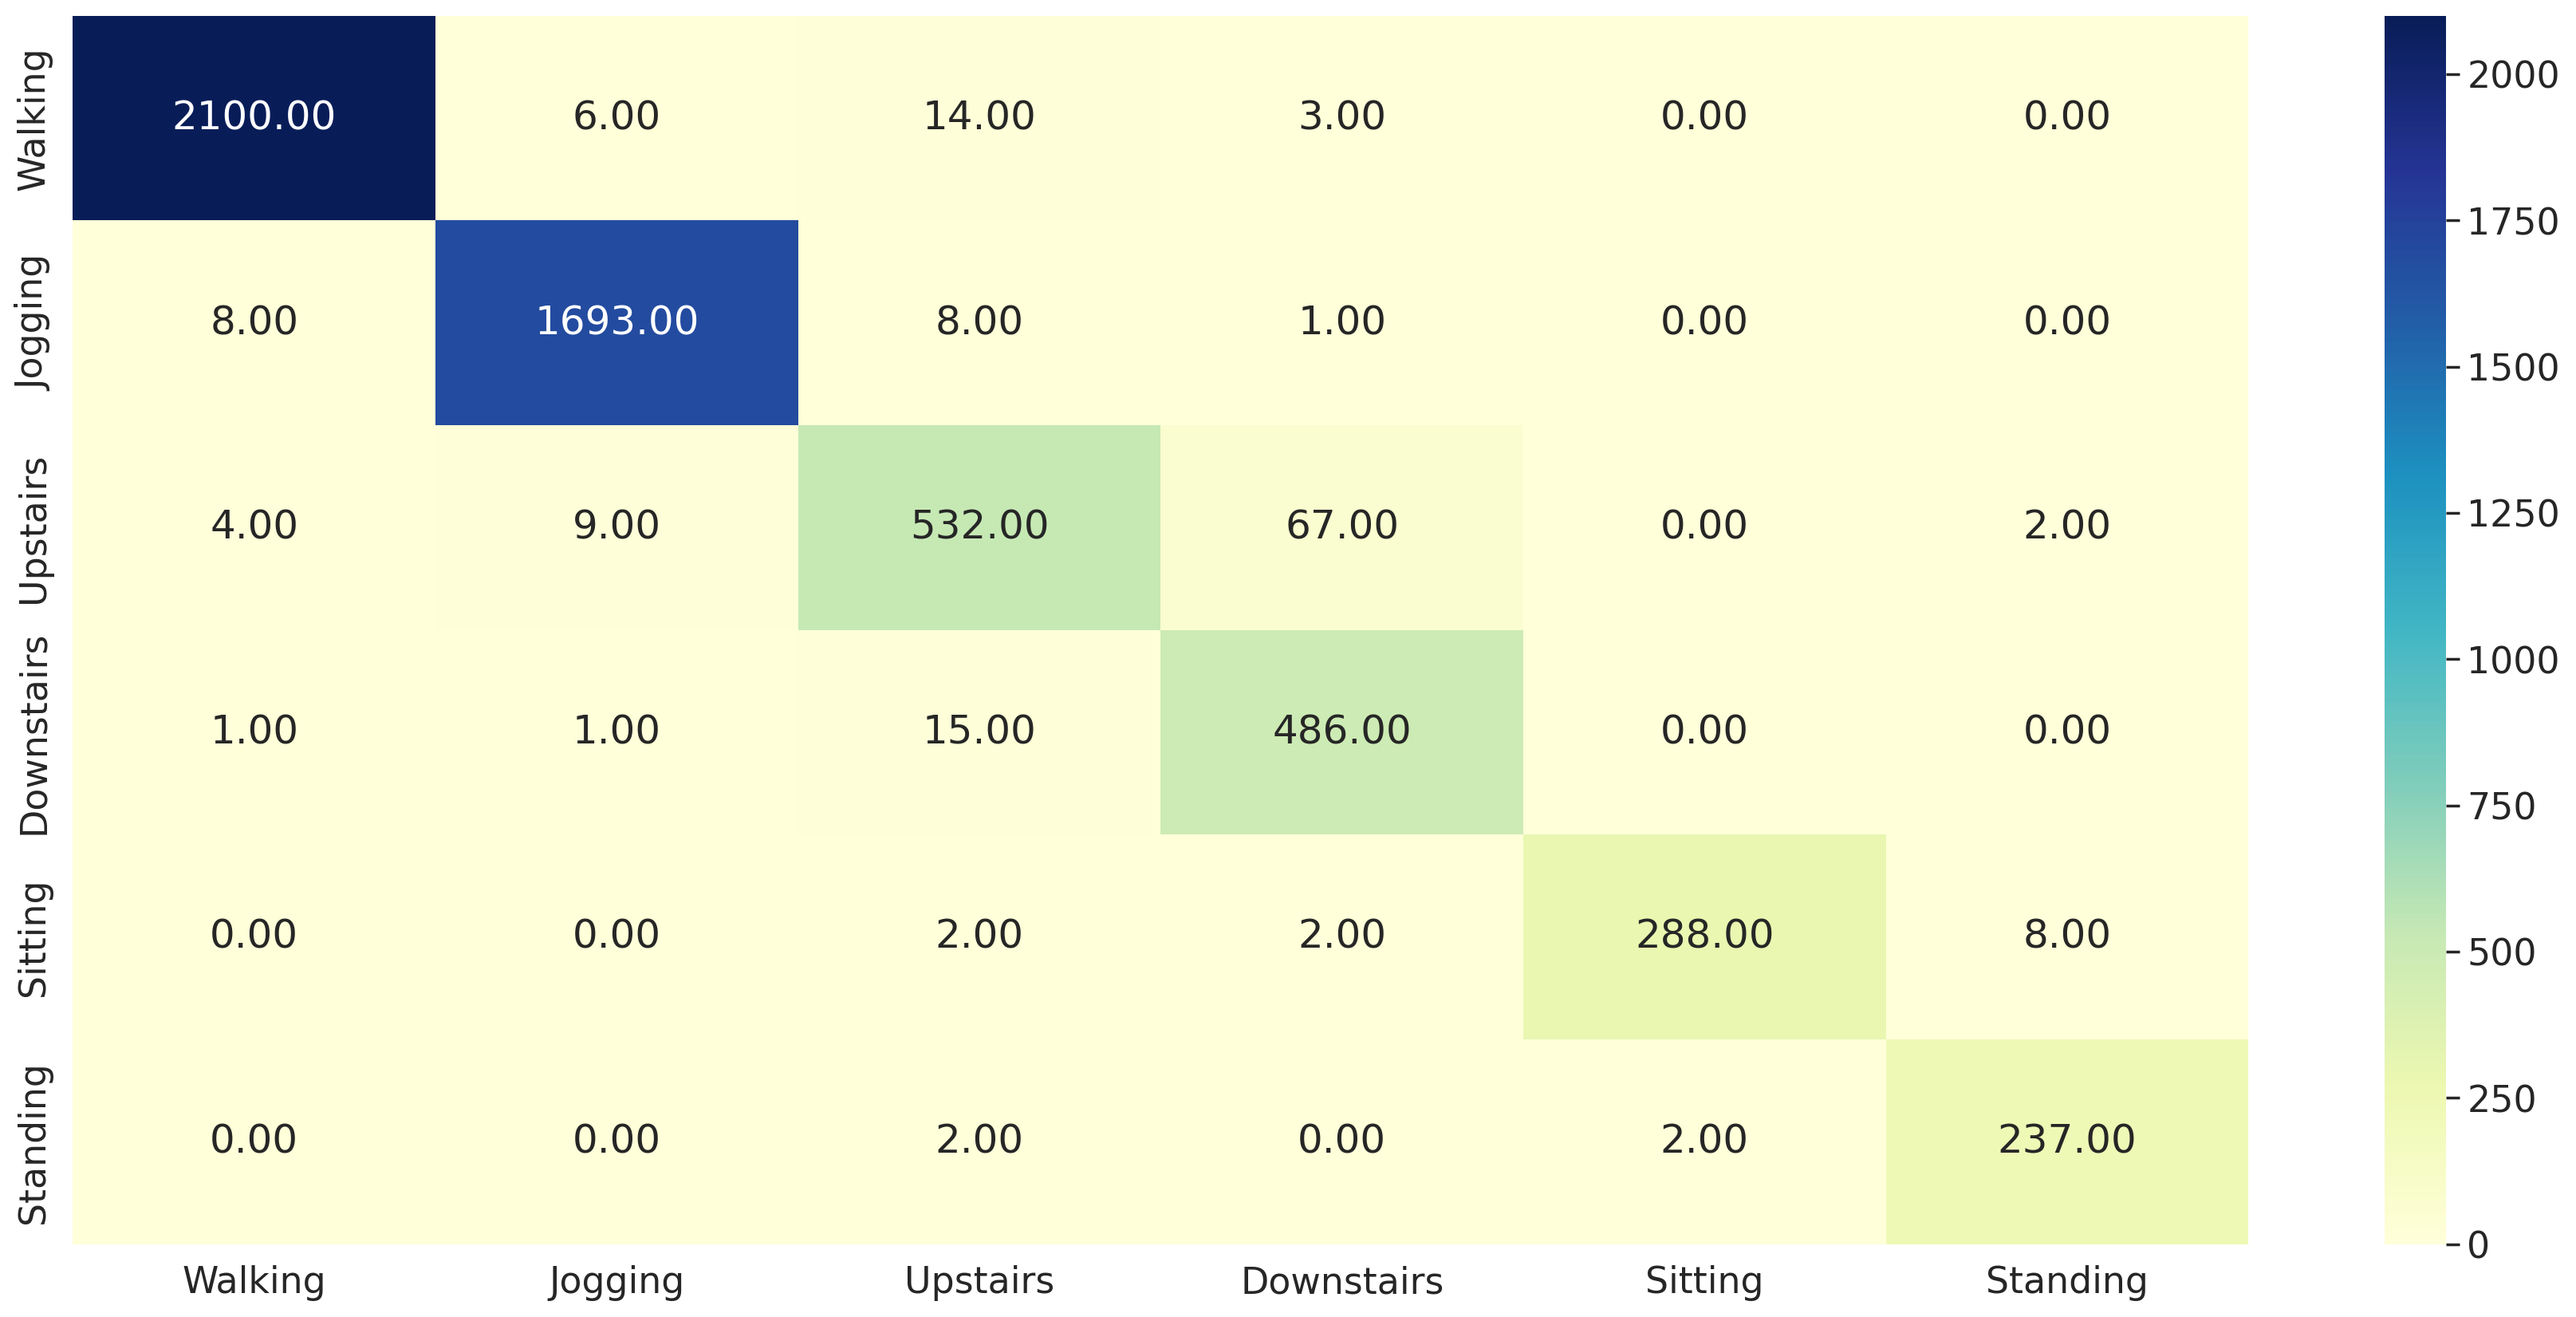

In [32]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')